In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import statsmodels.api as sm # for poisson regression
import statsmodels.formula.api as smf

from statsmodels.tsa.statespace.structural import UnobservedComponents # for state space method

import xgboost as xgb #for xboost

#import import_ipynb
from poisson_custom import get_season, sku_extract, zscore, plot_zscore, plot_cap_outliers, cap_outliers, fit_xgb_poisson, date_split, means_and_cor,poisson_regression, state_space, fit_ucm_and_evaluate, fit_xgb_poisson2, errors
# import import_ipynb

# from poisson_custom import sku_extract, zscore, plot_zscore, cap_outliners, plot_cap_outliers,date_split, means_and_corr
# from poisson_custom import poisson_regression,poisson_regression2

In [123]:
#how to run a single case SKU
filename = f"data/mock_test.csv"
df = pd.DataFrame()
df = pd.read_csv(filename,sep=',')
SKU_list = df['ITEM_CODE'].unique()
#df.drop_duplicates(subset=['ITEM_CODE', 'NAME'])
SKU = SKU_list[0]
df_cl=sku_extract(df, SKU)
df_cl['VALUE2'] = zscore(df_cl['VALUE'], window=120)
z, avg, std, m = zscore(df_cl['VALUE'], window=120, return_all=True)
plot_zscore(df_cl, z, avg, std, m)
date_split(df_cl)
plot_SKU(df_cl,y_col='VALUE2', title='Sold per day, no outliners')
df_cl.loc[:, 'VALUE2'].rolling(window=7).mean().plot(lw=2, color='blue', label='xx-day Rolling Mean')
results = fit_ucm_and_evaluate(df_cl, seasonality_col = 'Day_of_Week', test_size=0.2, plot=True)

print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])
results = fit_xgb_poisson(df_cl, test_size=0.2, max_lag=7, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])
var1 = results["var_test_sample"]


df_pred = generate_calendar('2025-09-01','2025-09-30')
df_pred = fit_xgb_poisson_out(df_cl, df_pred, 7, n=30)
df_out = pred_out(df_pred, SKU, var1)
plot_forecast_with_intervals(df_out)

n = len(df_pred)
filename_out=f"data/mock_out.csv"
#os.remove(filename_out)
if os.path.exists(filename_out):
    df_out.to_csv(filename_out, mode='a', index=False, header=False)
else:
    df_out.to_csv(filename_out, mode='w', index=False, header=True)


## functions extra

In [3]:
def plot_SKU(df_cl, y_col='VALUE', title='Sold per day'):
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_cl, x=df_cl.index, y=df_cl[y_col])
    # plt.ylim(0, 5)  # optional: uncomment to set y-axis limits
    plt.title(title)
    plt.ylabel('Sold')
    plt.xlabel('Days')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [4]:
import pandas as pd

def generate_calendar(start_date, end_date):
    
    # Create date range
    dates = pd.date_range(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), freq='D')
    
    # Build DataFrame
    df = pd.DataFrame({"Date": dates})
    df["Day"] = df["Date"].dt.day
    df["Month"] = df["Date"].dt.month
    df["Year"] = df["Date"].dt.year
    df["Day_of_Week"] = df["Date"].dt.dayofweek  

    df["Season"] = df["Month"].apply(get_season)
    
    return df


In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb

def fit_xgb_poisson_out(df_cl, df_pred, max_lag=3, n=30):
   

    df_tmp = pd.DataFrame({'y': df_cl['VALUE2'].values})
    for lag in range(1, max_lag + 1):
        df_tmp[f'lag{lag}'] = df_tmp['y'].shift(lag)

    df_tmp = df_tmp.dropna().reset_index(drop=True)

    # calendar added
    df_tmp['Month'] = df_cl['Month'].iloc[max_lag:].values
    df_tmp['Season'] = df_cl['Season'].iloc[max_lag:].values
    df_tmp['Day_of_Week'] = df_cl['Day_of_Week'].iloc[max_lag:].values

    # 2) Train XGBoost Poisson model
    X_train = df_tmp.drop(columns=['y'])
    y_train = df_tmp['y']

    model = xgb.XGBRegressor(
        objective='count:poisson',
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)

    # 3) Forecast next n steps using recursive lag updates
    preds_mean = []
    preds_int = []
    last_known = df_tmp.iloc[-1:].copy()

    for i in range(n):
        X_input = last_known.drop(columns=['y']).copy()
        pred_mean = model.predict(X_input)[0]
        preds_mean.append(pred_mean)

        # Convert to integer via Poisson sampling
        pred_int = np.random.poisson(lam=np.maximum(pred_mean, 0))
        preds_int.append(pred_int)

        # Update lag features for next step
        new_row = {}
        new_row['y'] = pred_int  # use integer for recursion
        for lag in range(1, max_lag + 1):
            if lag == 1:
                new_row[f'lag{lag}'] = pred_int
            else:
                new_row[f'lag{lag}'] = last_known[f'lag{lag-1}'].values[0]

        # Copy calendar features from df_pred
        for col in ['Month', 'Season', 'Day_of_Week']:
            new_row[col] = df_pred.iloc[i][col]

        last_known = pd.DataFrame([new_row])

    # 4) Add forecasts to df_pred
    df_pred = df_pred.copy()
    df_pred['FORECAST'] = preds_int  # integer forecasts

    return df_pred


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents

def state_space_out(df_cl, df_pred, n=30):
    
    y = df_cl['VALUE2'].values

    # exogs
    exog_cols = ['Month', 'Season', 'Day_of_Week']
    exog = df_cl[exog_cols].values if all(col in df_cl.columns for col in exog_cols) else None

    # Fit local-level state-space model
    mod = UnobservedComponents(endog=y, level='local level', exog=exog)
    res = mod.fit(disp=False)

    # Forecast future steps using exogenous values from df_pred
    exog_future = df_pred[exog_cols].values if exog is not None else None
    forecast_res = res.get_forecast(steps=n, exog=exog_future)

    # Predicted mean (float)
    pred_mean = forecast_res.predicted_mean

    # Convert to integers via Poisson sampling
    pred_integer = np.random.poisson(lam=np.maximum(pred_mean, 0))

    # Add forecasts to df_pred
    df_pred = df_pred.copy()
    df_pred['FORECAST'] = pred_integer

    return df_pred

In [7]:
def pred_out(df_pred, SKU, variance):
    df_out = df_pred.copy()
    df_out['ITEM_CODE'] = SKU
    n=len(df_pred.index)
    # Standard error from variance
    std = np.sqrt(variance)

    # Z-scores for intervals
    z_scores = {
        95: 1.96,
        97: 2.17,   
        99: 2.58
    }
    
    for level, z in z_scores.items():
        df_out[f"LOWER_{level}"] = df_out["FORECAST"] - z * std
        df_out[f"UPPER_{level}"] = df_out["FORECAST"] + z * std
        
    df_out = df_out[['Date', 'ITEM_CODE','FORECAST', 'LOWER_95', 'UPPER_95', 'LOWER_97', 'UPPER_97', 'LOWER_99', 'UPPER_99']]
    return df_out

In [8]:
import matplotlib.pyplot as plt

def plot_forecast_with_intervals(df):
    
    plt.figure(figsize=(12, 6))

    # Plot predicted values
    plt.plot(df['Date'], df['FORECAST'], label='Predicted', color='blue', marker='o')

    # Shade confidence intervals
    plt.fill_between(df['Date'], df['LOWER_95'], df['UPPER_95'], color='blue', alpha=0.2, label='95% CI')
    plt.fill_between(df['Date'], df['LOWER_97'], df['UPPER_97'], color='green', alpha=0.15, label='97% CI')
    plt.fill_between(df['Date'], df['LOWER_99'], df['UPPER_99'], color='red', alpha=0.1, label='99% CI')

    # Labels & legend
    plt.xlabel('Date')
    plt.ylabel('Predicted Value')
    plt.title('Forecast with Prediction Intervals')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## SKU bunch

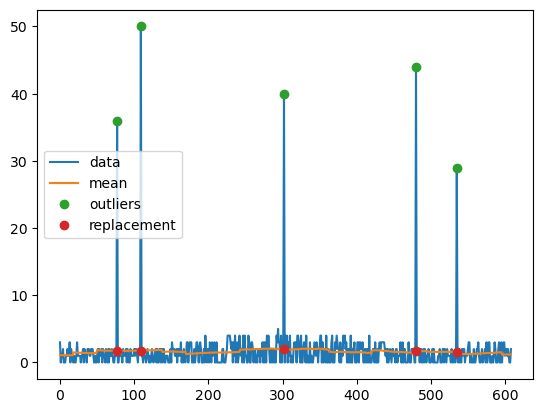

In [122]:
filename = f"data/mock_test.csv"
df = pd.DataFrame()
df = pd.read_csv(filename,sep=',')
SKU_list = df['ITEM_CODE'].unique()
#df.drop_duplicates(subset=['ITEM_CODE', 'NAME'])
SKU = SKU_list[0]
df_cl=sku_extract(df, SKU)
df_cl['VALUE2'] = zscore(df_cl['VALUE'], window=120)
z, avg, std, m = zscore(df_cl['VALUE'], window=120, return_all=True)
plot_zscore(df_cl, z, avg, std, m)
date_split(df_cl)
plot_SKU(df_cl,y_col='VALUE2', title='Sold per day, no outliners')
df_cl.loc[:, 'VALUE2'].rolling(window=7).mean().plot(lw=2, color='blue', label='xx-day Rolling Mean')
results = fit_ucm_and_evaluate(df_cl, seasonality_col = 'Day_of_Week', test_size=0.2, plot=True)

print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])
results = fit_xgb_poisson(df_cl, test_size=0.2, max_lag=7, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])
var1 = results["var_test_sample"]


df_pred = generate_calendar('2025-09-01','2025-09-30')
df_pred = fit_xgb_poisson_out(df_cl, df_pred, 7, n=30)
df_out = pred_out(df_pred, SKU, var1)
plot_forecast_with_intervals(df_out)

n = len(df_pred)
filename_out=f"data/mock_out.csv"
#os.remove(filename_out)
if os.path.exists(filename_out):
    df_out.to_csv(filename_out, mode='a', index=False, header=False)
else:
    df_out.to_csv(filename_out, mode='w', index=False, header=True)

## SKU 111900-A

In [9]:
SKU = '111900-A'
df_cl=sku_extract(df, SKU)

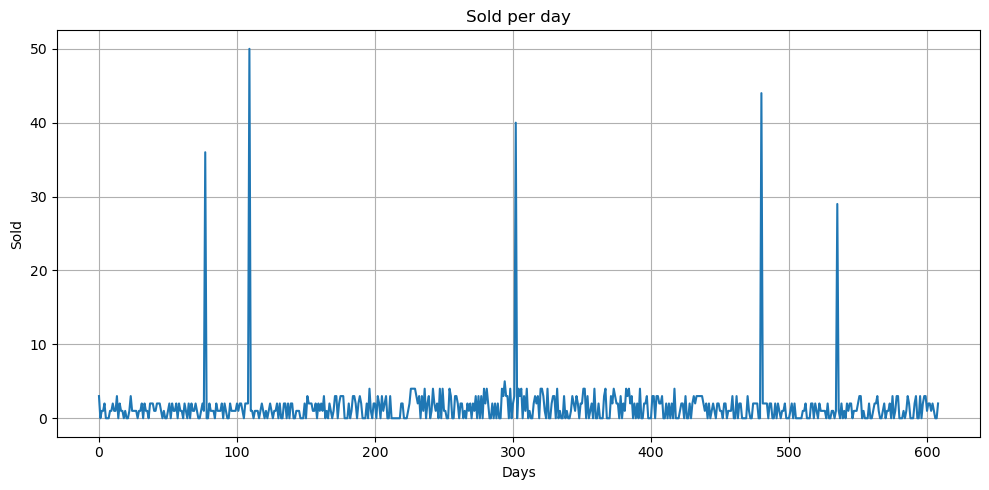

In [10]:
plot_SKU(df_cl,y_col='VALUE', title='Sold per day')

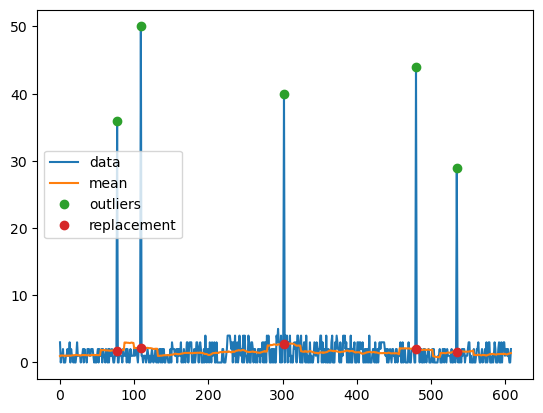

In [11]:
# outl=20
# df_cl['VALUE2'] = cap_outliers(df_cl, col='VALUE', outl=outl)['VALUE']
# plot_cap_outliers(df_cl['VALUE'],df_cl['VALUE2'],outl)
df_cl['VALUE2'] = zscore(df_cl['VALUE'], window=30)
z, avg, std, m = zscore(df_cl['VALUE'], window=45, return_all=True)
plot_zscore(df_cl, z, avg, std, m)

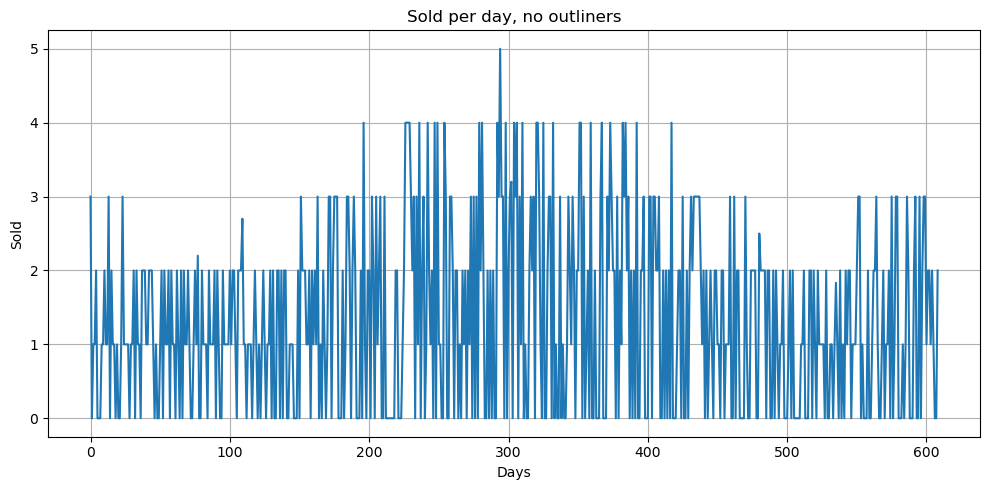

In [12]:
plot_SKU(df_cl,y_col='VALUE2', title='Sold per day, no outliners')

In [13]:
date_split(df_cl)
print(df_cl['Season'].unique())

[2 3 0 1]


<Axes: >

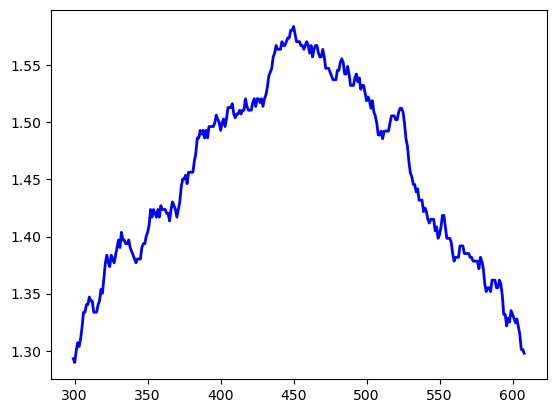

In [14]:
df_cl.loc[:, 'VALUE2'].rolling(window=300).mean().plot(
    lw=2, color='blue', label='xx-day Rolling Mean'
)

In [15]:
# df_agg_month = df_cl.groupby(["Year", "Month"], as_index=False).agg({'VALUE2': 'sum'})
# #plot on sold items monthly
# sns.lineplot(data=df_agg_month, x=df_agg_month.index, y=df_agg_month['VALUE2'])
# #plt.ylim(0,5)
# plt.title('Number of sold items, month')
# plt.ylabel('Sold')
# plt.xlabel("Month")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [16]:
means_and_cor(df_cl)

--- Average 'VALUE' per Day of Week ---
   Day_of_Week  Mean_Value
0            0    1.393103
1            1    1.255172
2            2    1.425287
3            3    1.308429
4            4    1.335632
5            5    1.298851
6            6    1.172414

--- Pearson Correlation Coefficient ---
Correlation between Day of Week and Mean Value: -0.6064
Correlation between VALUE2 and Day_of_Week: -0.038916079679099755

--- Average 'VALUE' per Month ---
    Month  Mean_Value
0       1    1.419355
1       2    1.245614
2       3    1.277419
3       4    1.170000
4       5    0.854839
5       6    1.197222
6       7    1.258065
7       8    1.467742
8       9    1.466667
9      10    1.877419
10     11    1.833333
11     12    1.290323

--- Pearson Correlation Coefficient ---
Correlation between Month and Mean Value: 0.5131
Correlation between VALUE2 and Month: 0.08764809837768078
--- Average 'VALUE2' per Season ---
   Season  Mean_Value
0       0    1.308877
1       1    1.727473
2       2 

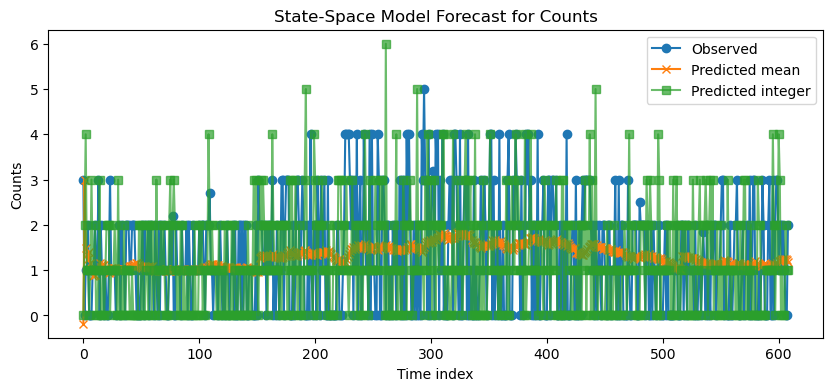

In [18]:
state_space(df_cl, seasonality_col = 'Season')

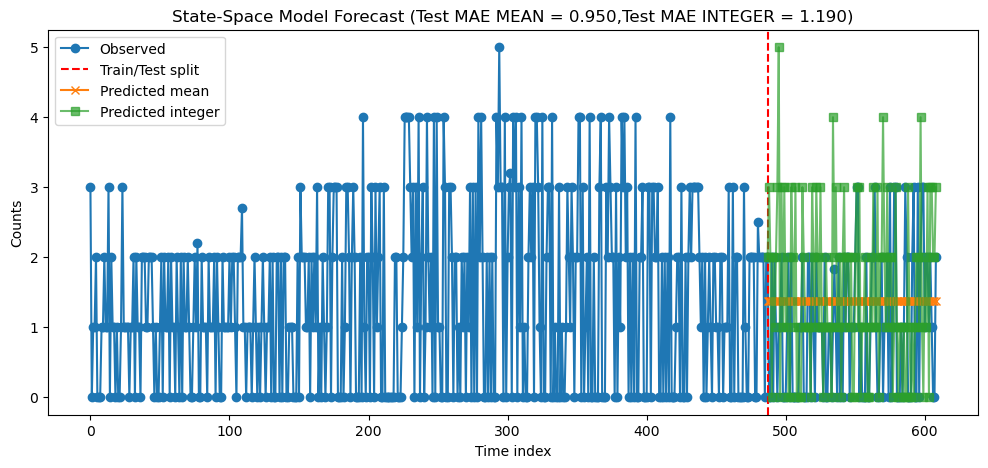

Test MAE (mean): 0.9495022029189077
Test MAE (integer): 1.1898907103825138
Test MAPE (mean): 0.37358956230705886
Test MAPE (integer): 0.7044416770444167


In [19]:
results = fit_ucm_and_evaluate(df_cl, seasonality_col = 'Month', test_size=0.2, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])

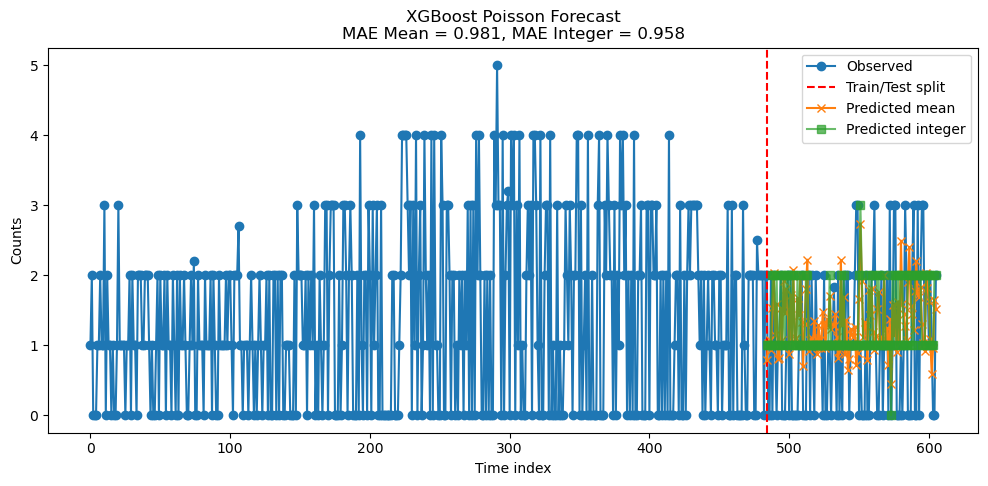

Test MAE (mean): 0.9810298250509741
Test MAE (integer): 0.9576502732240437
Test MAPE (mean): 0.4162454395533697
Test MAPE (integer): 0.35782482357824824
Samle (test) variance: 1.4602846648301195


In [20]:
results = fit_xgb_poisson(df_cl, test_size=0.2, max_lag=3, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])
var1 = results["var_test_sample"]

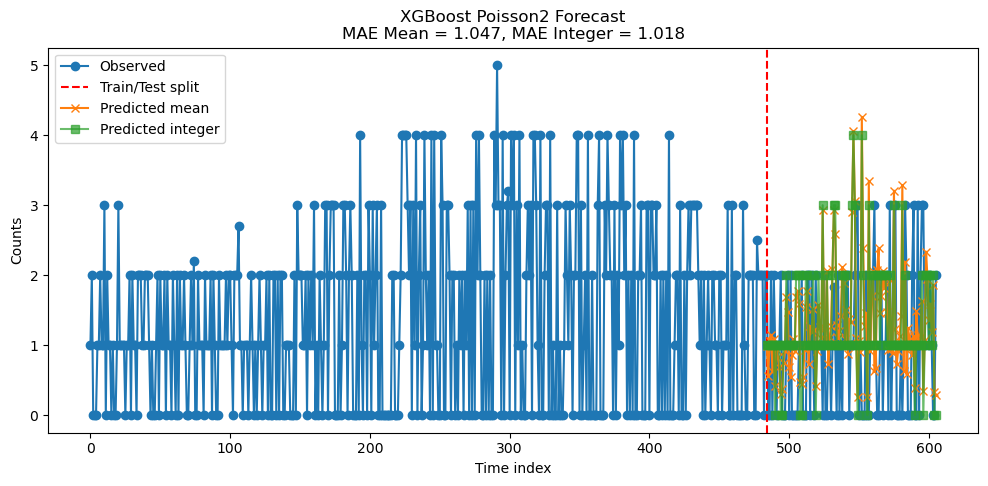

MAE (mean): 1.047
MAE (integer): 1.018
MAPE (%) mean: 0.50%
MAPE (%) integer: 0.48%


In [21]:
results = fit_xgb_poisson2(df_cl, test_size=0.2, max_lag=3)
print(f"MAE (mean): {results['mae_mean']:.3f}")
print(f"MAE (integer): {results['mae_integer']:.3f}")
print(f"MAPE (%) mean: {results['mape_mean']:.2f}%")
print(f"MAPE (%) integer: {results['mape_integer']:.2f}%")

In [22]:
df_pred = generate_calendar('2025-09-01','2025-09-30')

In [23]:
df_pred = fit_xgb_poisson_out(df_cl, df_pred, max_lag=3, n=30)

In [24]:
df_out = pred_out(df_pred, SKU, var1)

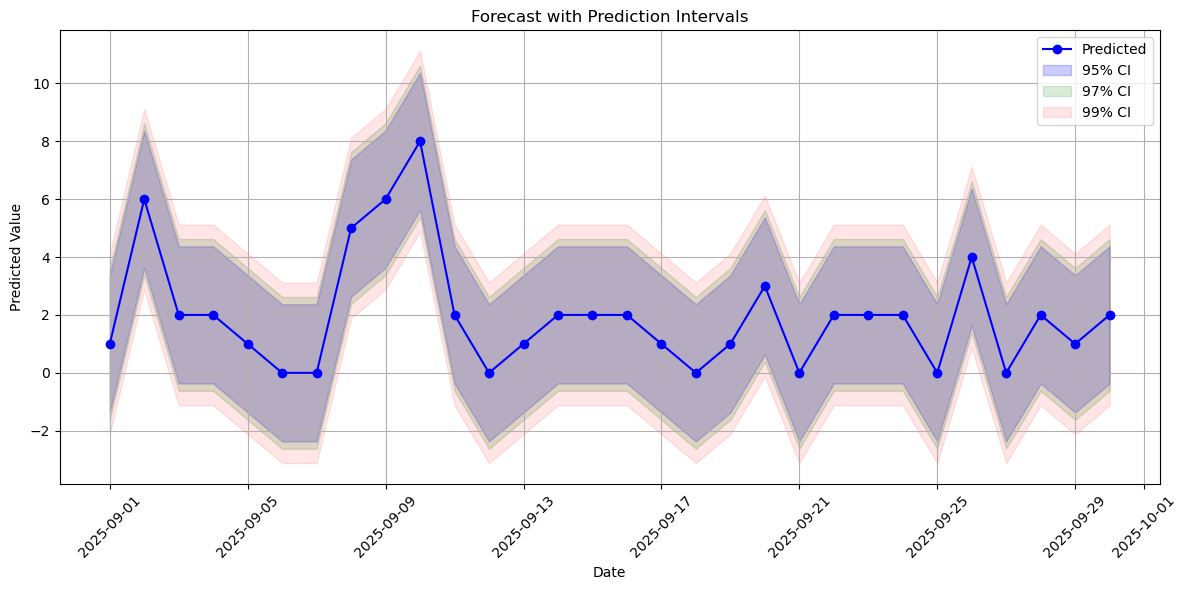

In [25]:
plot_forecast_with_intervals(df_out)

In [26]:
filename_out=f"data/mock_out.csv"
#os.remove(filename_out)

In [27]:
if os.path.exists(filename_out):
    df_out.to_csv(filename_out, mode='a', index=False, header=False)
else:
    df_out.to_csv(filename_out, mode='w', index=False, header=True)

## SKU 111934-A

In [28]:
SKU = '111934-A'
df_cl=sku_extract(df, SKU)

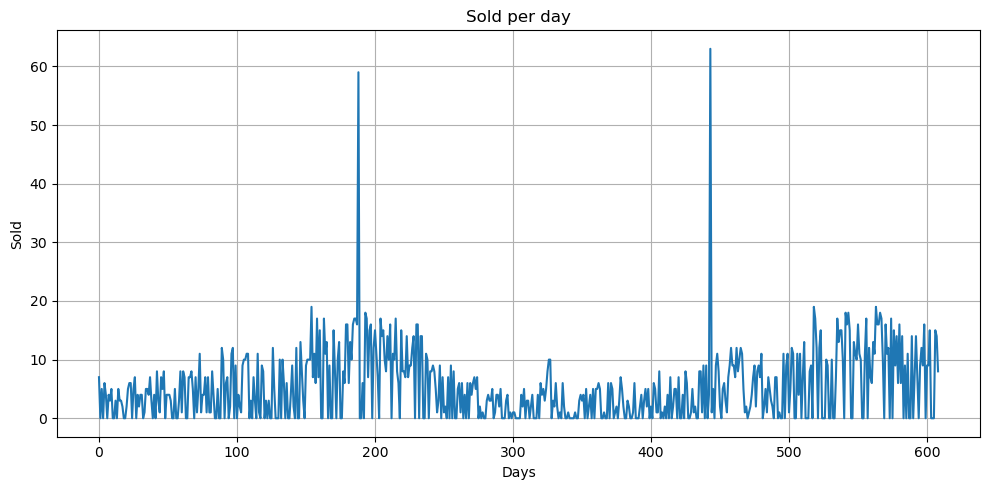

In [29]:
plot_SKU(df_cl,y_col='VALUE', title='Sold per day')

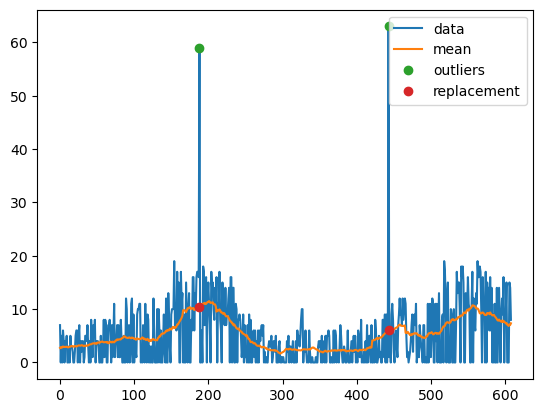

In [30]:
# outl=20
# df_cl['VALUE2'] = cap_outliers(df_cl, col='VALUE', outl=outl)['VALUE']
# plot_cap_outliers(df_cl['VALUE'],df_cl['VALUE2'],outl)
df_cl['VALUE2'] = zscore(df_cl['VALUE'], window=30)
z, avg, std, m = zscore(df_cl['VALUE'], window=45, return_all=True)
plot_zscore(df_cl, z, avg, std, m)

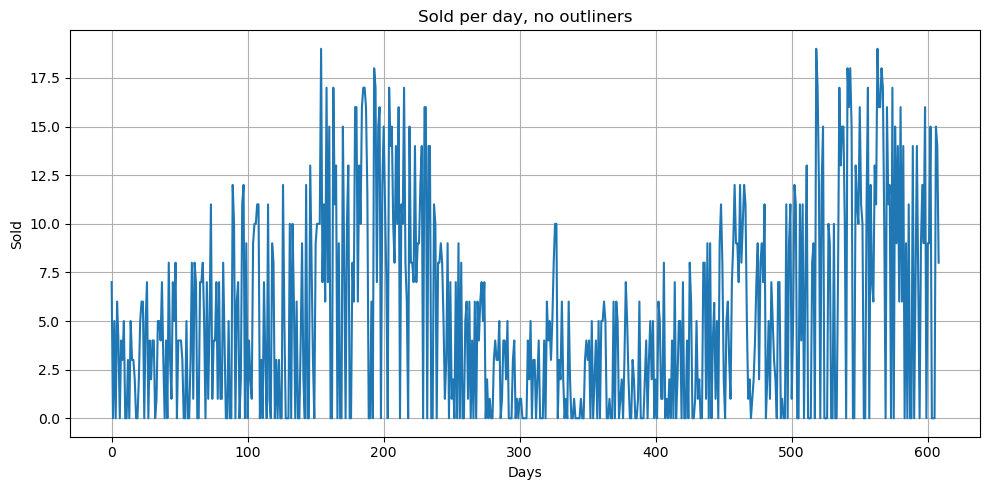

In [31]:
plot_SKU(df_cl,y_col='VALUE2', title='Sold per day, no outliners')

In [32]:
date_split(df_cl)
print(df_cl['Season'].unique())

[2 3 0 1]


<Axes: >

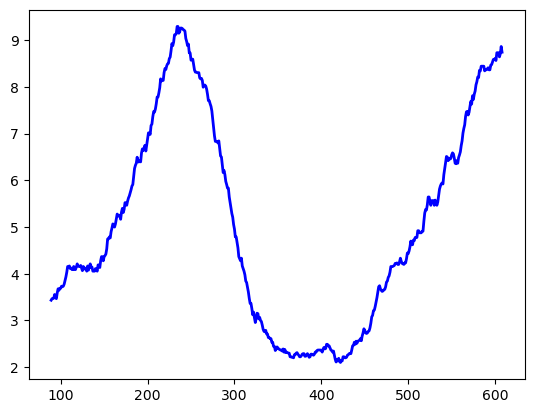

In [33]:
df_cl.loc[:, 'VALUE2'].rolling(window=90).mean().plot(
    lw=2, color='blue', label='xx-day Rolling Mean'
)

In [34]:
means_and_cor(df_cl)

--- Average 'VALUE' per Day of Week ---
   Day_of_Week  Mean_Value
0            0    4.919540
1            1    4.321839
2            2    5.079693
3            3    5.689655
4            4    5.333333
5            5    5.643678
6            6    5.178927

--- Pearson Correlation Coefficient ---
Correlation between Day of Week and Mean Value: 0.6066
Correlation between VALUE2 and Day_of_Week: 0.05078471751345609

--- Average 'VALUE' per Month ---
    Month  Mean_Value
0       1    2.500000
1       2    2.859649
2       3    4.047312
3       4    5.600000
4       5    4.403226
5       6    8.300000
6       7   10.525269
7       8    8.112903
8       9    3.600000
9      10    1.741935
10     11    3.066667
11     12    1.967742

--- Pearson Correlation Coefficient ---
Correlation between Month and Mean Value: -0.0747
Correlation between VALUE2 and Month: 0.07735695428704123
--- Average 'VALUE2' per Season ---
   Season  Mean_Value
0       0    8.986775
1       1    2.791209
2       2   

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  609
Model:                            GLM   Df Residuals:                      606
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2459.6
Date:                Wed, 10 Sep 2025   Deviance:                       3385.6
Time:                        13:47:18   Pearson chi2:                 2.96e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2612
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2700      0.040     32.009      0.0

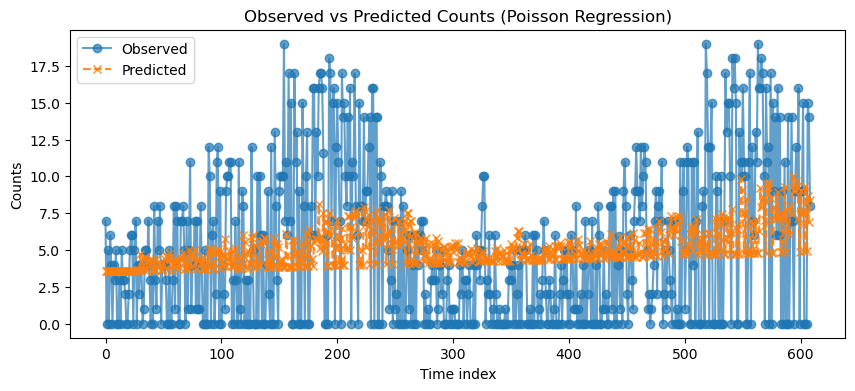

In [35]:
_ = poisson_regression(df_cl)

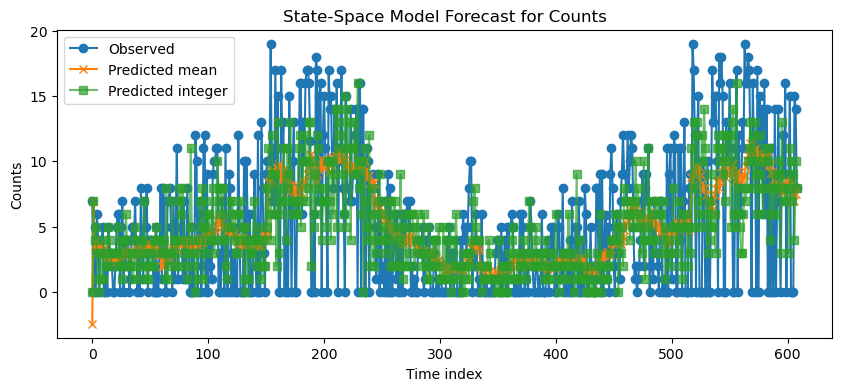

In [36]:
state_space(df_cl, seasonality_col = 'Season')

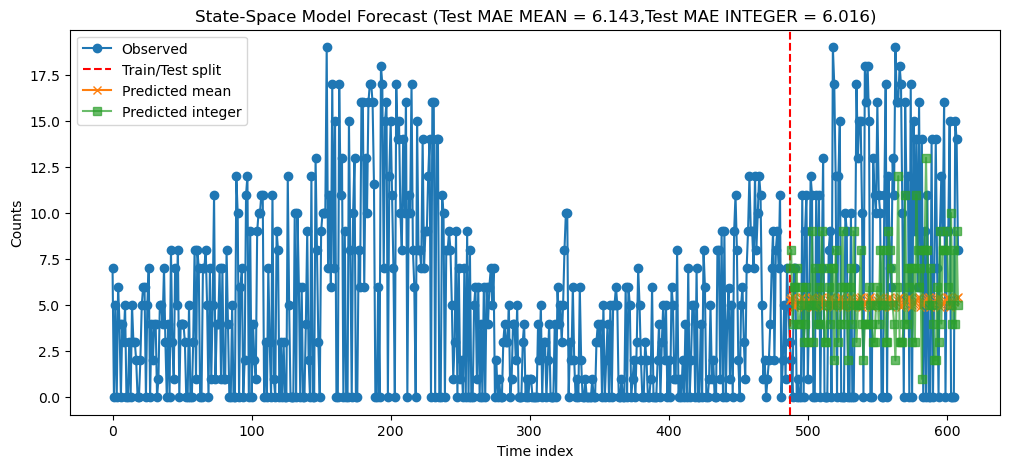

Test MAE (mean): 6.1429294320583585
Test MAE (integer): 6.016393442622951
Test MAPE (mean): 0.6250854080186692
Test MAPE (integer): 0.5772384914561982
Samle (test) variance: 51.107438016528924


In [37]:
results = fit_ucm_and_evaluate(df_cl, seasonality_col = 'Day_of_Week', test_size=0.2, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])
var1 = results["var_test_sample"]

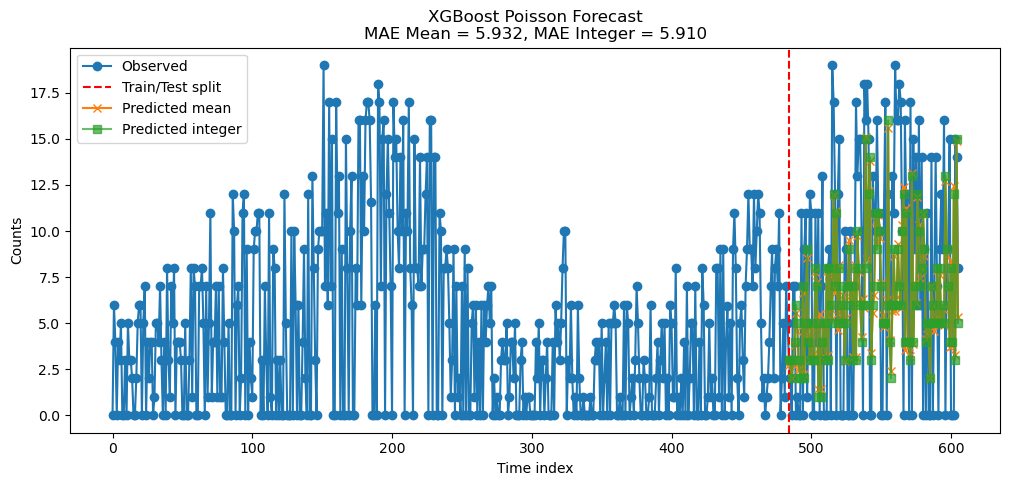

MAE (mean): 5.932
MAE (integer): 5.910
MAPE (%) mean: 0.59%
MAPE (%) integer: 0.59%
Samle (test) variance: 49.429752066115704


In [38]:
results = fit_xgb_poisson(df_cl, test_size=0.2, max_lag=3)
print(f"MAE (mean): {results['mae_mean']:.3f}")
print(f"MAE (integer): {results['mae_integer']:.3f}")
print(f"MAPE (%) mean: {results['mape_mean']:.2f}%")
print(f"MAPE (%) integer: {results['mape_integer']:.2f}%")
print("Samle (test) variance:", results["var_test_sample"])


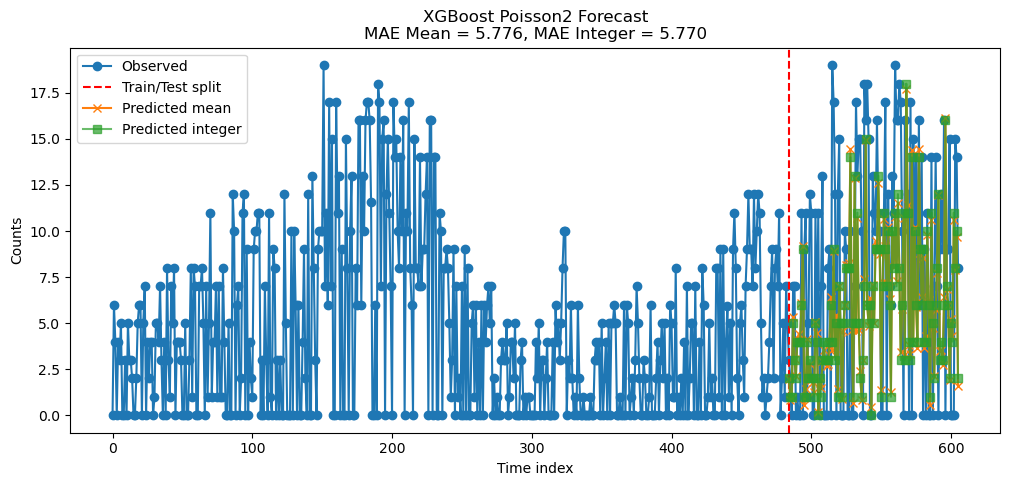

MAE (mean): 5.776
MAE (integer): 5.770
MAPE (%) mean: 0.57%
MAPE (%) integer: 0.57%
Samle (test) variance: 48.710743801652896


In [39]:
results = fit_xgb_poisson2(df_cl, test_size=0.2, max_lag=3)
print(f"MAE (mean): {results['mae_mean']:.3f}")
print(f"MAE (integer): {results['mae_integer']:.3f}")
print(f"MAPE (%) mean: {results['mape_mean']:.2f}%")
print(f"MAPE (%) integer: {results['mape_integer']:.2f}%")
print("Samle (test) variance:", results["var_test_sample"])

In [40]:
df_pred = generate_calendar('2025-09-01','2025-09-30')
df_pred = state_space_out(df_cl, df_pred, n=30)
df_out = pred_out(df_pred, SKU, var1)

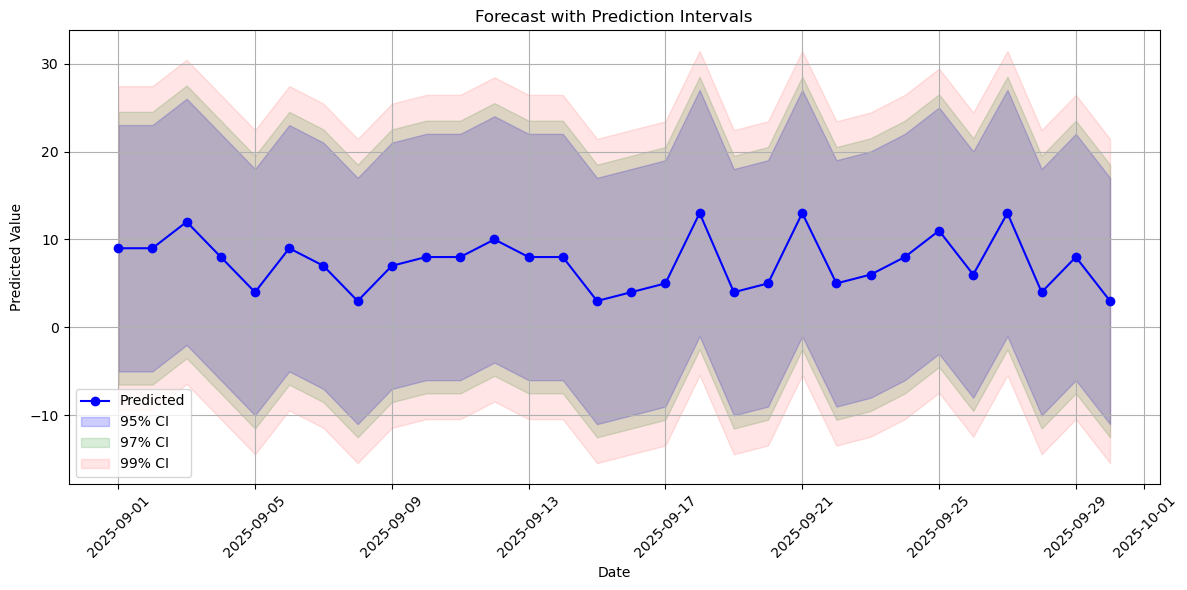

In [41]:
plot_forecast_with_intervals(df_out)

In [42]:
filename_out=f"data/mock_out.csv"
#os.remove(filename_out)

In [43]:
if os.path.exists(filename_out):
    df_out.to_csv(filename_out, mode='a', index=False, header=False)
else:
    df_out.to_csv(filename_out, mode='w', index=False, header=True)

## SKU 121234-A

In [44]:
SKU = '121234-A'
df_cl=sku_extract(df, SKU)

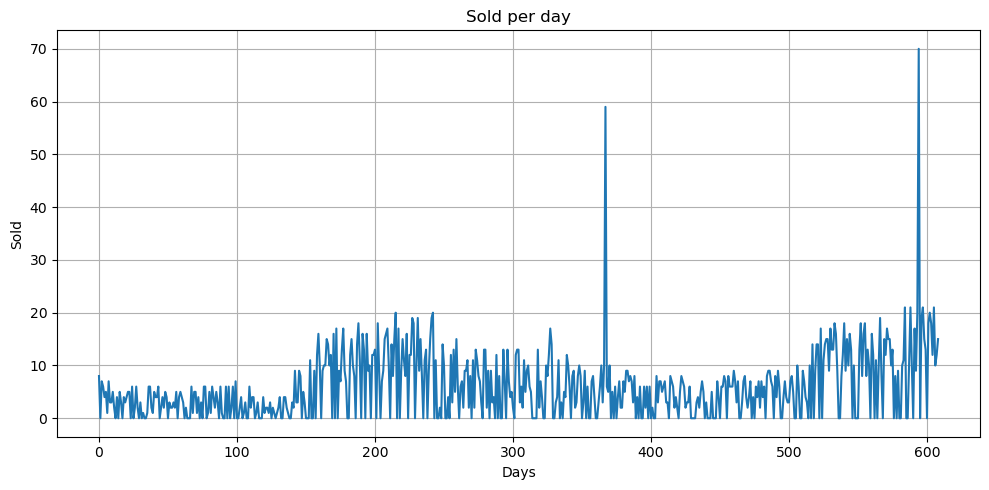

In [45]:
plot_SKU(df_cl,y_col='VALUE', title='Sold per day')

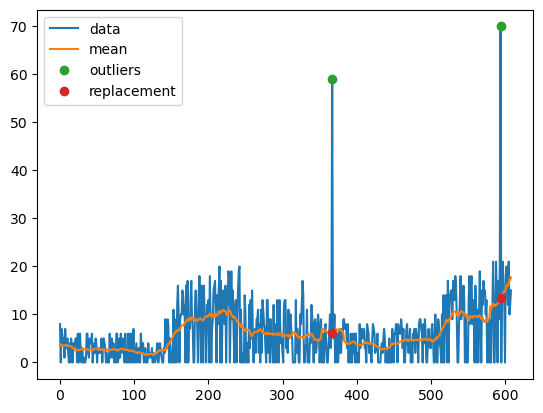

In [46]:
# outl=20
# df_cl['VALUE2'] = cap_outliers(df_cl, col='VALUE', outl=outl)['VALUE']
# plot_cap_outliers(df_cl['VALUE'],df_cl['VALUE2'],outl)
df_cl['VALUE2'] = zscore(df_cl['VALUE'], window=30)
z, avg, std, m = zscore(df_cl['VALUE'], window=30, return_all=True)
plot_zscore(df_cl, z, avg, std, m)

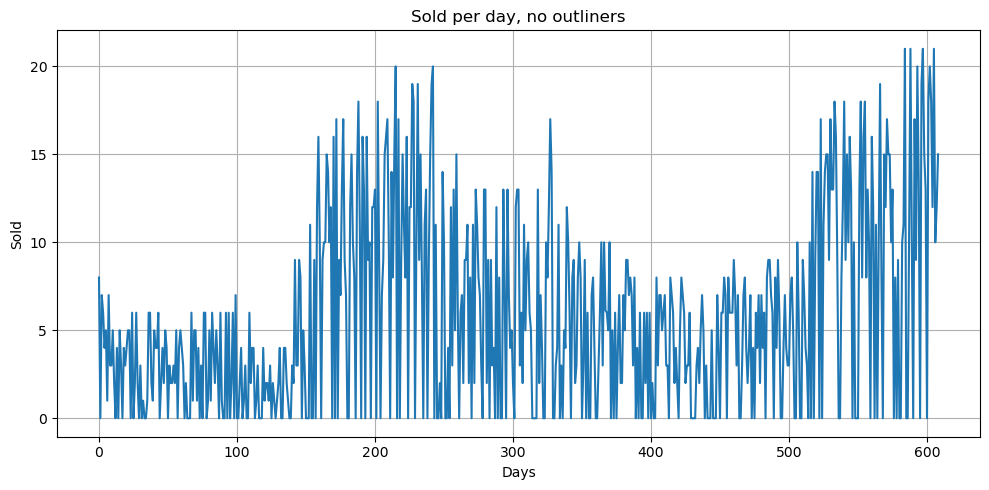

In [47]:
plot_SKU(df_cl,y_col='VALUE2', title='Sold per day, no outliners')

In [48]:
date_split(df_cl)
print(df_cl['Season'].unique())

[2 3 0 1]


<Axes: >

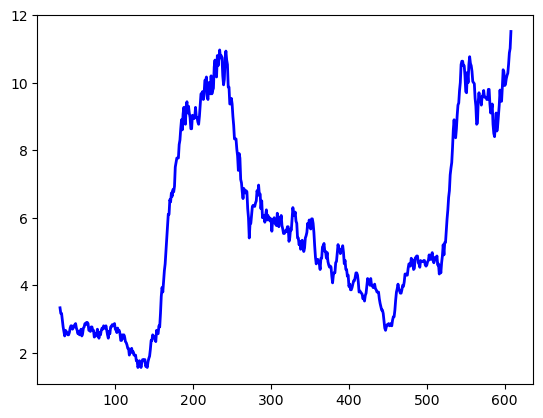

In [49]:
df_cl.loc[:, 'VALUE2'].rolling(window=30).mean().plot(
    lw=2, color='blue', label='xx-day Rolling Mean'
)

In [50]:
means_and_cor(df_cl)

--- Average 'VALUE' per Day of Week ---
   Day_of_Week  Mean_Value
0            0    5.310345
1            1    5.425287
2            2    6.149425
3            3    6.484291
4            4    5.264368
5            5    5.724138
6            6    6.200000

--- Pearson Correlation Coefficient ---
Correlation between Day of Week and Mean Value: 0.3773
Correlation between VALUE2 and Day_of_Week: 0.03125082497108364

--- Average 'VALUE' per Month ---
    Month  Mean_Value
0       1    3.986022
1       2    3.456140
2       3    2.677419
3       4    3.433333
4       5    3.435484
5       6    9.200000
6       7    9.661290
7       8   10.861290
8       9    5.833333
9      10    6.161290
10     11    5.400000
11     12    4.741935

--- Pearson Correlation Coefficient ---
Correlation between Month and Mean Value: 0.3894
Correlation between VALUE2 and Month: 0.2610647358734308
--- Average 'VALUE2' per Season ---
   Season  Mean_Value
0       0    9.915217
1       1    5.802198
2       2    3

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  609
Model:                            GLM   Df Residuals:                      606
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2432.9
Date:                Wed, 10 Sep 2025   Deviance:                       3208.3
Time:                        13:47:27   Pearson chi2:                 2.76e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4157
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1827      0.040     29.804      0.0

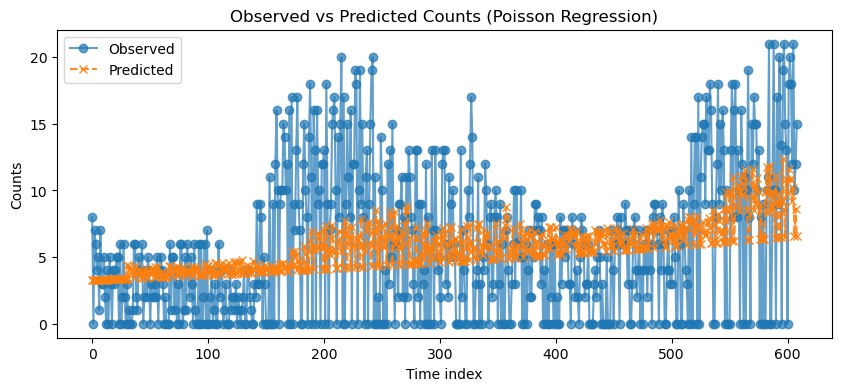

In [51]:
_ = poisson_regression(df_cl)

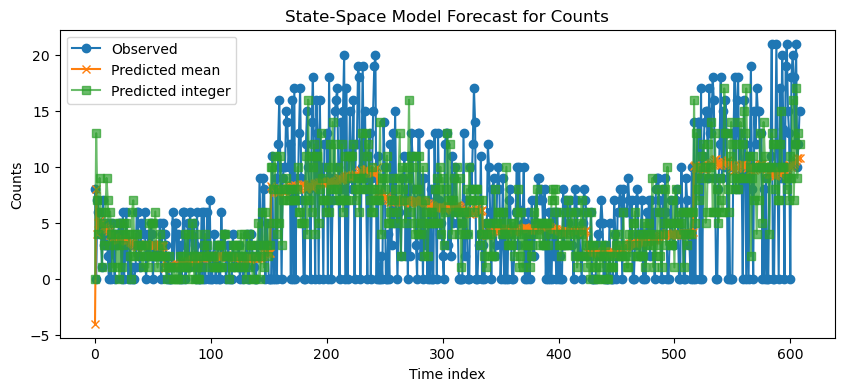

In [52]:
state_space(df_cl, seasonality_col = 'Season')

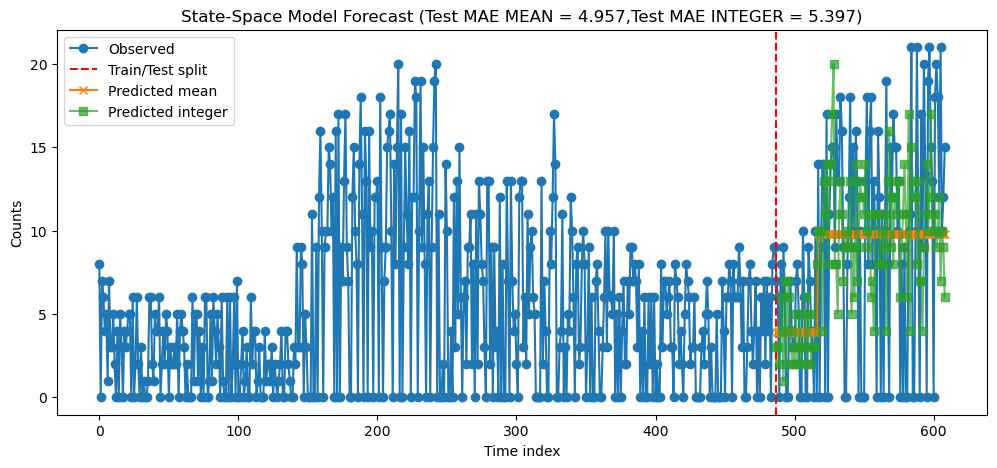

Test MAE (mean): 4.956753063904513
Test MAE (integer): 5.396721311475409
Test MAPE (mean): 0.2908111157943899
Test MAPE (integer): 0.3471694431125387
Samle (test) variance: 45.43603305785124


In [53]:
results = fit_ucm_and_evaluate(df_cl, seasonality_col = 'Season', test_size=0.2, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])

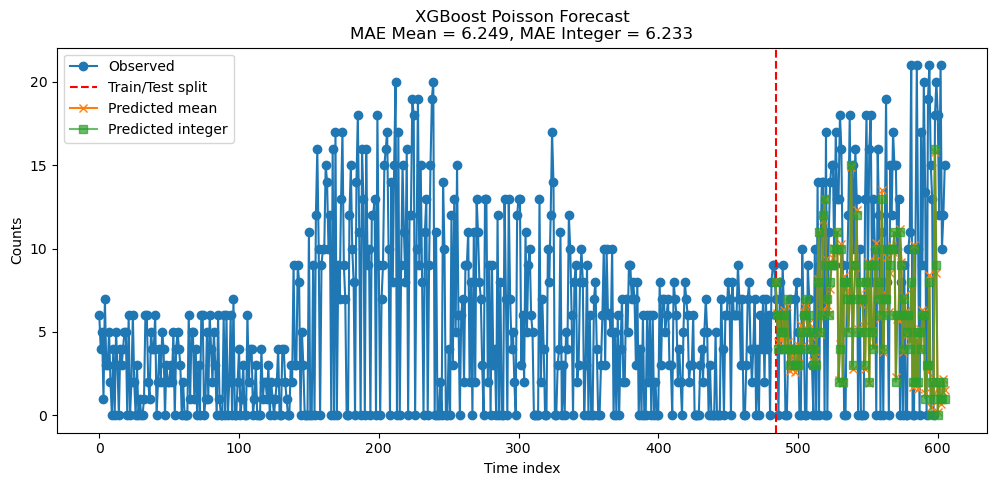

Test MAE (mean): 6.248733450594496
Test MAE (integer): 6.232786885245901
Test MAPE (mean): 0.471002546501477
Test MAPE (integer): 0.4723194068401273
Samle (test) variance: 58.95669421487604


In [54]:
results = fit_xgb_poisson(df_cl, test_size=0.2, max_lag=3, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])
var1 = results["var_test_sample"]

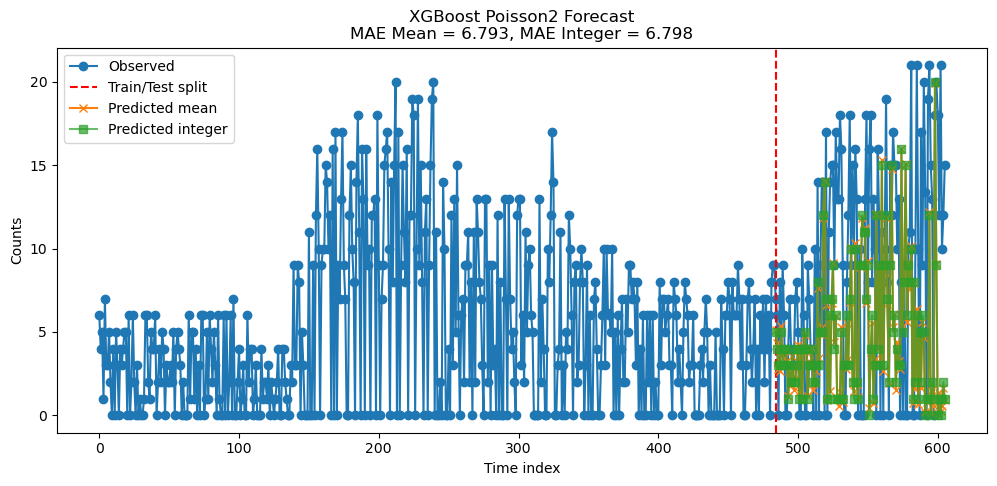

MAE (mean): 6.793
MAE (integer): 6.798
MAPE (%) mean: 0.59%
MAPE (%) integer: 0.58%
Samle (test) variance: 70.93851239669421


In [55]:
results = fit_xgb_poisson2(df_cl, test_size=0.2, max_lag=3)
print(f"MAE (mean): {results['mae_mean']:.3f}")
print(f"MAE (integer): {results['mae_integer']:.3f}")
print(f"MAPE (%) mean: {results['mape_mean']:.2f}%")
print(f"MAPE (%) integer: {results['mape_integer']:.2f}%")
print("Samle (test) variance:", results["var_test_sample"])

In [56]:
df_pred = generate_calendar('2025-09-01','2025-09-30')
n = len(df_pred)

In [57]:
df_pred = state_space_out(df_cl, df_pred, n)

In [58]:
df_out = pred_out(df_pred, SKU, var1)

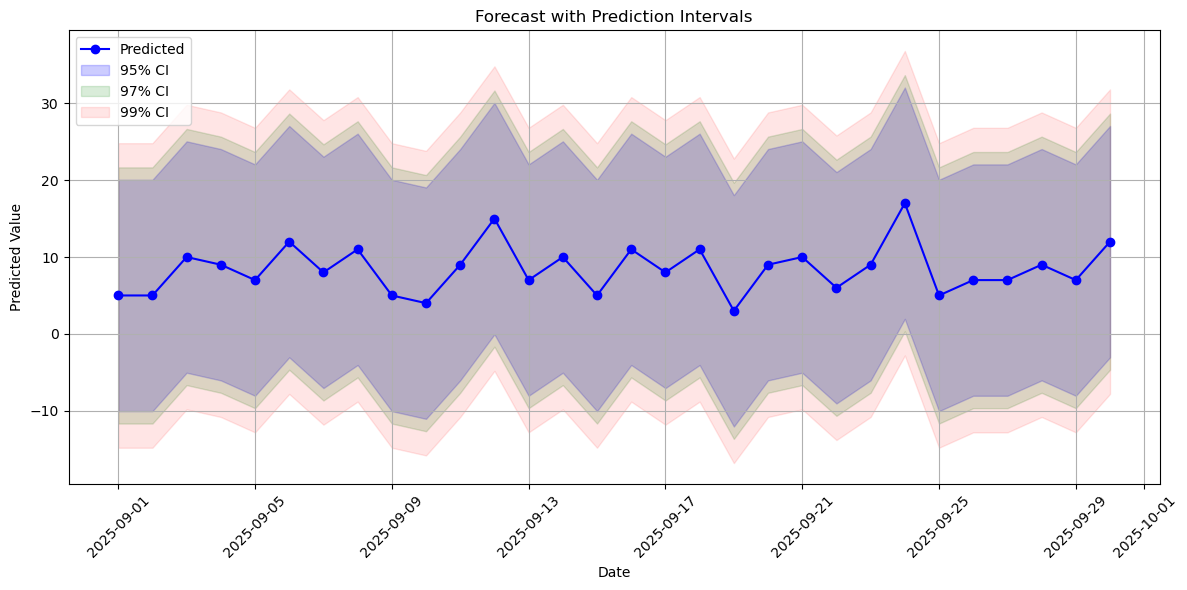

In [59]:
plot_forecast_with_intervals(df_out)

In [60]:
filename_out=f"data/mock_out.csv"
#os.remove(filename_out)

In [61]:
if os.path.exists(filename_out):
    df_out.to_csv(filename_out, mode='a', index=False, header=False)
else:
    df_out.to_csv(filename_out, mode='w', index=False, header=True)

## SKU 121914-A

In [62]:
SKU = '121914-A'
df_cl=sku_extract(df, SKU)

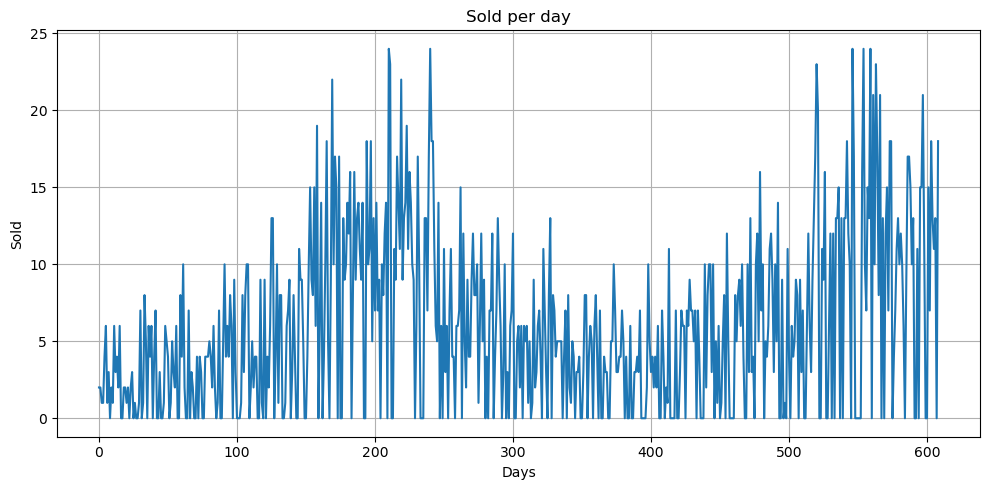

In [63]:
plot_SKU(df_cl,y_col='VALUE', title='Sold per day')

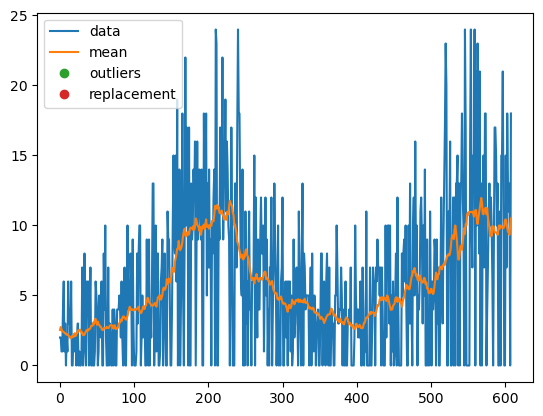

In [64]:
# outl=20
# df_cl['VALUE2'] = cap_outliers(df_cl, col='VALUE', outl=outl)['VALUE']
# plot_cap_outliers(df_cl['VALUE'],df_cl['VALUE2'],outl)
df_cl['VALUE2'] = zscore(df_cl['VALUE'], window=30)
z, avg, std, m = zscore(df_cl['VALUE'], window=30, return_all=True)
plot_zscore(df_cl, z, avg, std, m)

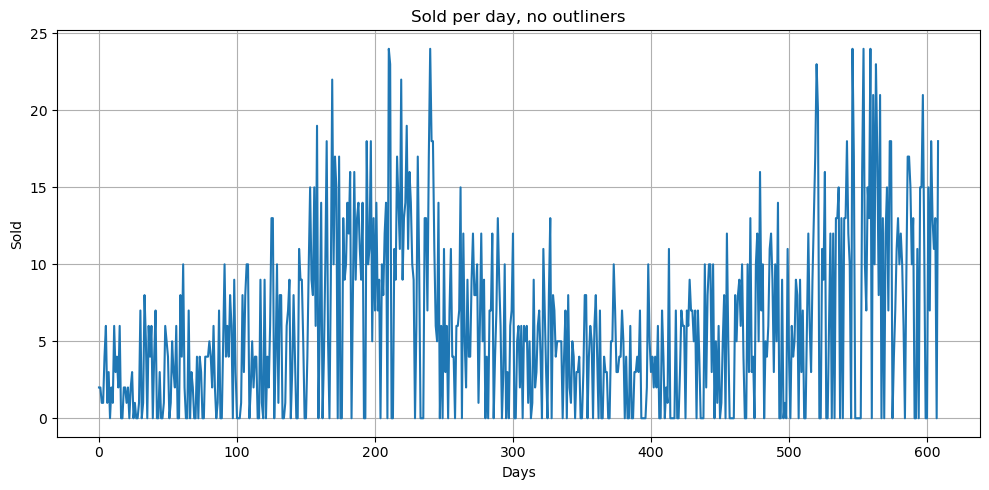

In [65]:
plot_SKU(df_cl,y_col='VALUE2', title='Sold per day, no outliners')

In [66]:
date_split(df_cl)
print(df_cl['Season'].unique())

[2 3 0 1]


<Axes: >

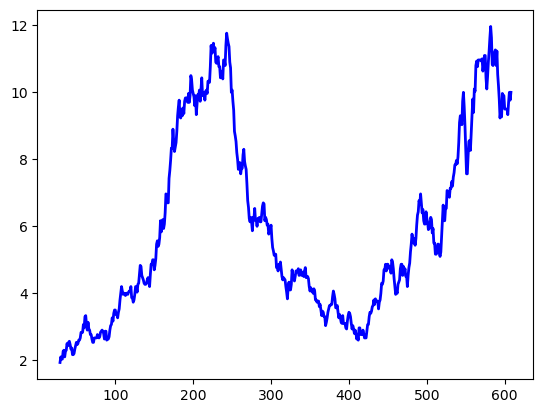

In [67]:
df_cl.loc[:, 'VALUE2'].rolling(window=30).mean().plot(
    lw=2, color='blue', label='xx-day Rolling Mean'
)

In [68]:
means_and_cor(df_cl)

--- Average 'VALUE' per Day of Week ---
   Day_of_Week  Mean_Value
0            0    6.448276
1            1    6.413793
2            2    5.954023
3            3    5.758621
4            4    5.563218
5            5    5.908046
6            6    5.758621

--- Pearson Correlation Coefficient ---
Correlation between Day of Week and Mean Value: -0.7929
Correlation between VALUE2 and Day_of_Week: -0.04399812472144581

--- Average 'VALUE' per Month ---
    Month  Mean_Value
0       1    2.548387
1       2    3.105263
2       3    3.758065
3       4    4.816667
4       5    5.032258
5       6    9.650000
6       7   10.209677
7       8   10.709677
8       9    6.133333
9      10    5.290323
10     11    4.633333
11     12    3.387097

--- Pearson Correlation Coefficient ---
Correlation between Month and Mean Value: 0.2558
Correlation between VALUE2 and Month: 0.22090782176723572
--- Average 'VALUE2' per Season ---
   Season  Mean_Value
0       0   10.195652
1       1    5.351648
2       2  

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  609
Model:                            GLM   Df Residuals:                      606
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2540.3
Date:                Wed, 10 Sep 2025   Deviance:                       3400.8
Time:                        13:47:36   Pearson chi2:                 2.97e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2915
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3428      0.038     35.469      0.0

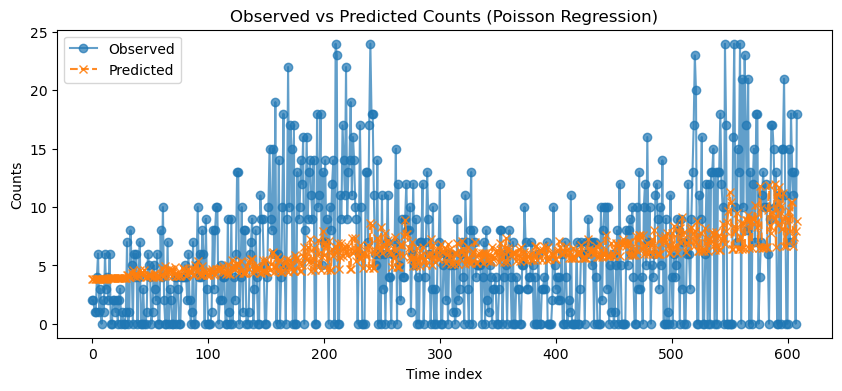

In [69]:
_ = poisson_regression(df_cl)

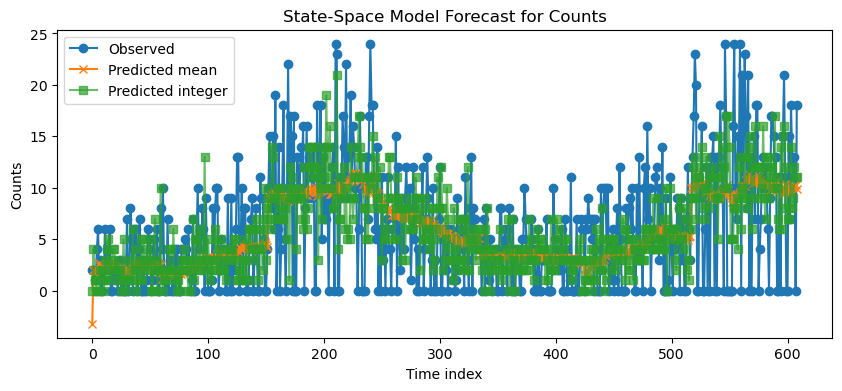

In [70]:
state_space(df_cl, seasonality_col = 'Season')

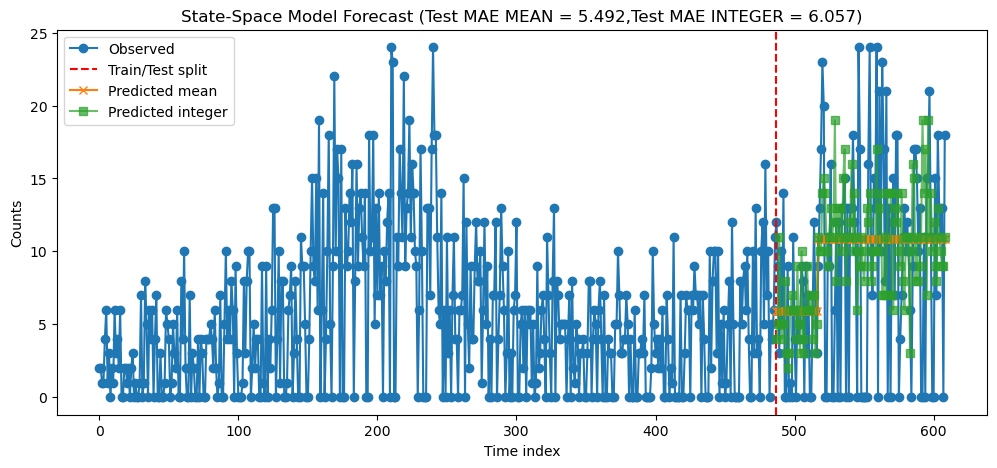

Test MAE (mean): 5.49237221307139
Test MAE (integer): 6.057377049180328
Test MAPE (mean): 0.3814635113256814
Test MAPE (integer): 0.47955797156312974
Samle (test) variance: 54.33884297520661


In [71]:
results = fit_ucm_and_evaluate(df_cl, seasonality_col = 'Season', test_size=0.2, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])

In [72]:
df_pred = generate_calendar('2025-09-01','2025-09-30')
n = len(df_pred)

In [73]:
df_pred = state_space_out(df_cl, df_pred, n)

In [74]:
df_out = pred_out(df_pred, SKU, var1)

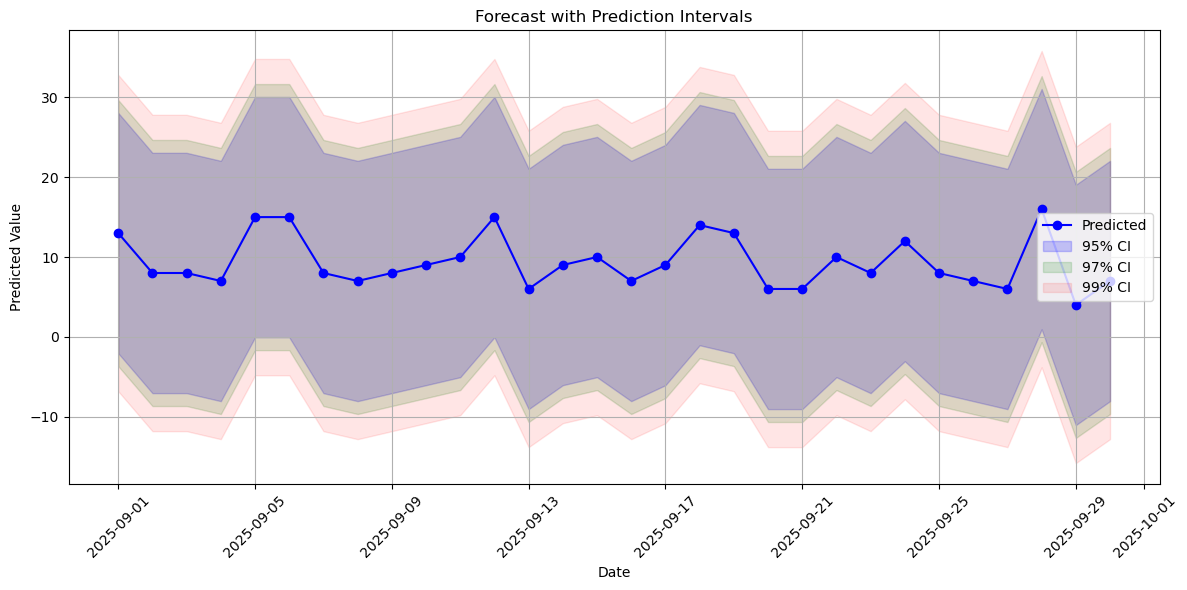

In [75]:
plot_forecast_with_intervals(df_out)

In [76]:
filename_out=f"data/mock_out.csv"
#os.remove(filename_out)

In [77]:
if os.path.exists(filename_out):
    df_out.to_csv(filename_out, mode='a', index=False, header=False)
else:
    df_out.to_csv(filename_out, mode='w', index=False, header=True)

## SKU 121987-A

In [78]:
SKU = '121987-A'
df_cl=sku_extract(df, SKU)

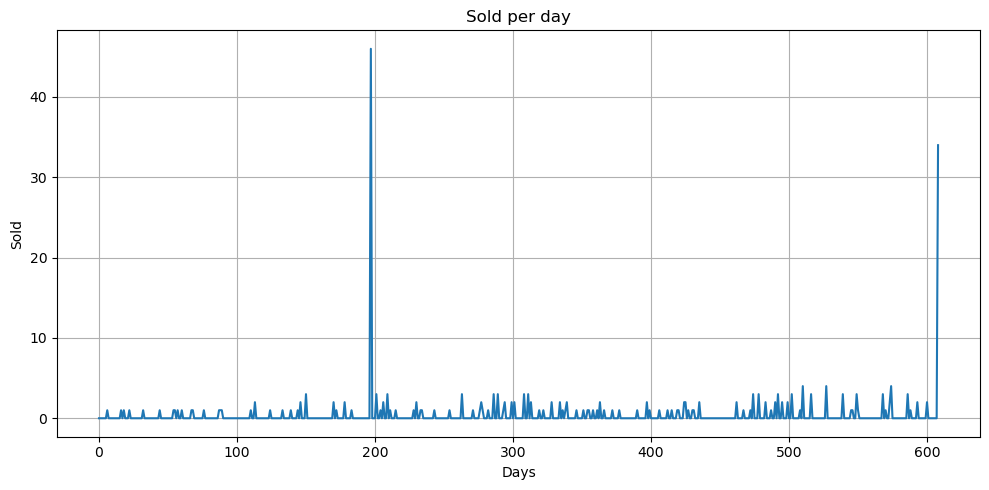

In [79]:
plot_SKU(df_cl,y_col='VALUE', title='Sold per day')

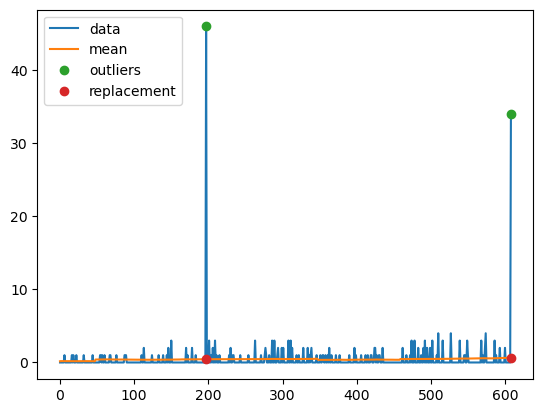

In [80]:
# df_cl['VALUE2'] = cap_outliers(df_cl, col='VALUE', outl=5)['VALUE']
# plot_cap_outliers(df_cl['VALUE'],df_cl['VALUE2'],outl=5)

df_cl['VALUE2'] = zscore(df_cl['VALUE'], window=300)
z, avg, std, m = zscore(df_cl['VALUE'], window=300, return_all=True)
plot_zscore(df_cl, z, avg, std, m)

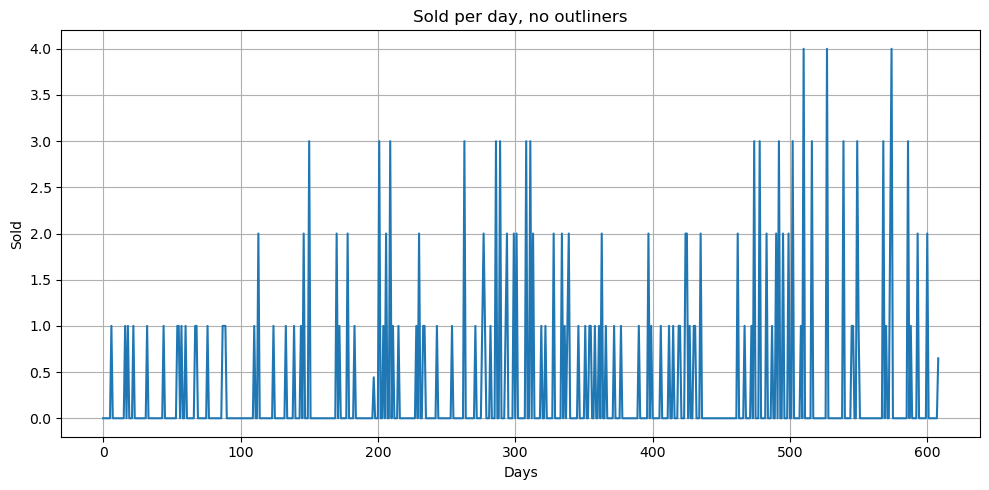

In [81]:
plot_SKU(df_cl,y_col='VALUE2', title='Sold per day, no outliners')

In [82]:
date_split(df_cl)
print(df_cl['Season'].unique())

[2 3 0 1]


<Axes: >

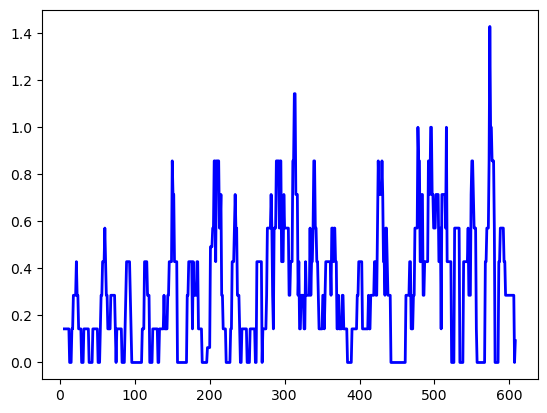

In [83]:
df_cl.loc[:, 'VALUE2'].rolling(window=7).mean().plot(
    lw=2, color='blue', label='xx-day Rolling Mean'
)

In [84]:
means_and_cor(df_cl)

--- Average 'VALUE' per Day of Week ---
   Day_of_Week  Mean_Value
0            0    0.333333
1            1    0.177510
2            2    0.287356
3            3    0.252874
4            4    0.252874
5            5    0.494253
6            6    0.340793

--- Pearson Correlation Coefficient ---
Correlation between Day of Week and Mean Value: 0.4798
Correlation between VALUE2 and Day_of_Week: 0.061158181895339433

--- Average 'VALUE' per Month ---
    Month  Mean_Value
0       1    0.129032
1       2    0.263158
2       3    0.225806
3       4    0.250000
4       5    0.483871
5       6    0.233333
6       7    0.410376
7       8    0.252403
8       9    0.166667
9      10    0.580645
10     11    0.466667
11     12    0.387097

--- Pearson Correlation Coefficient ---
Correlation between Month and Mean Value: 0.5570
Correlation between VALUE2 and Month: 0.09609088672406778
--- Average 'VALUE2' per Season ---
   Season  Mean_Value
0       0    0.299415
1       1    0.406593
2       2   

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  609
Model:                            GLM   Df Residuals:                      606
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -457.20
Date:                Wed, 10 Sep 2025   Deviance:                       644.16
Time:                        13:47:40   Pearson chi2:                     974.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02593
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6561      0.166     -9.960      0.0

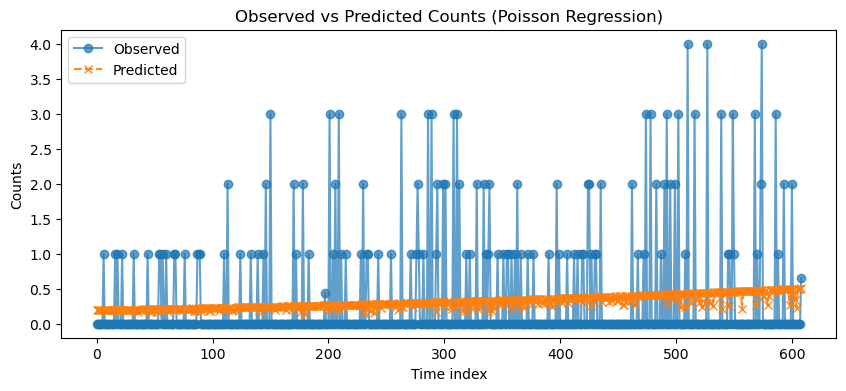

In [85]:
_ = poisson_regression(df_cl)

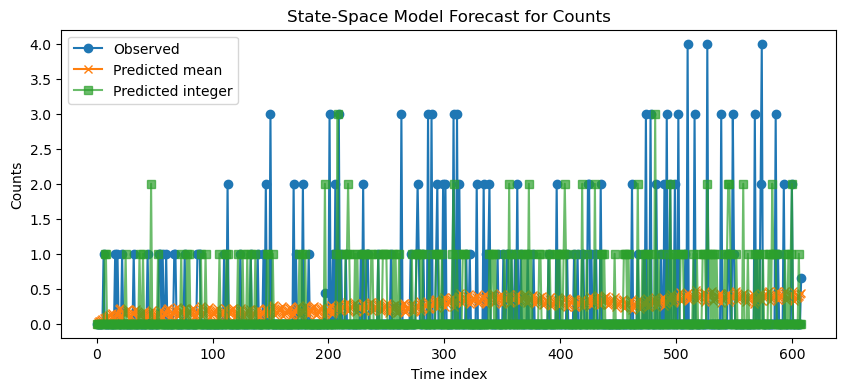

In [86]:
state_space(df_cl, seasonality_col = 'Day_of_Week')

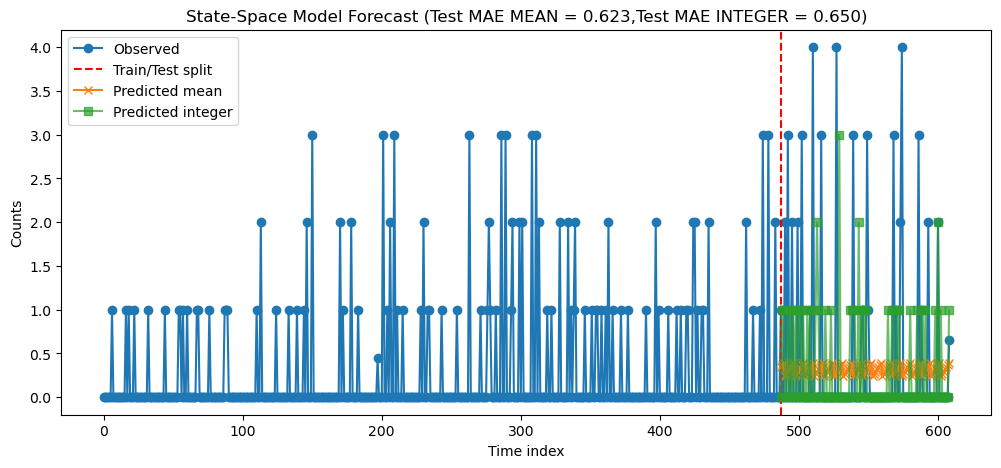

Test MAE (mean): 0.6229110339916394
Test MAE (integer): 0.6504179785039627
Test MAPE (mean): 0.7991731135314536
Test MAPE (integer): 0.772534013605442
Samle (test) variance: 1.3646545152978282


In [87]:
results = fit_ucm_and_evaluate(df_cl, seasonality_col = 'Day_of_Week', test_size=0.2, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])

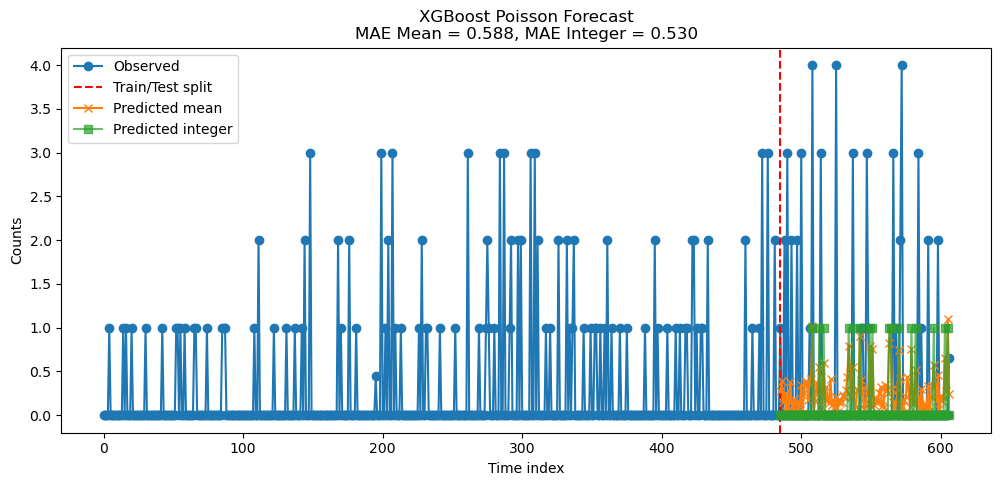

Test MAE (mean): 0.5877362526086709
Test MAE (integer): 0.5299098903484963
Test MAPE (mean): 0.8181463729879499
Test MAPE (integer): 0.9756944444444443
Samle (test) variance: 1.193563715670003


In [88]:
results = fit_xgb_poisson(df_cl, test_size=0.2, max_lag=2, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])
var1 = results["var_test_sample"]

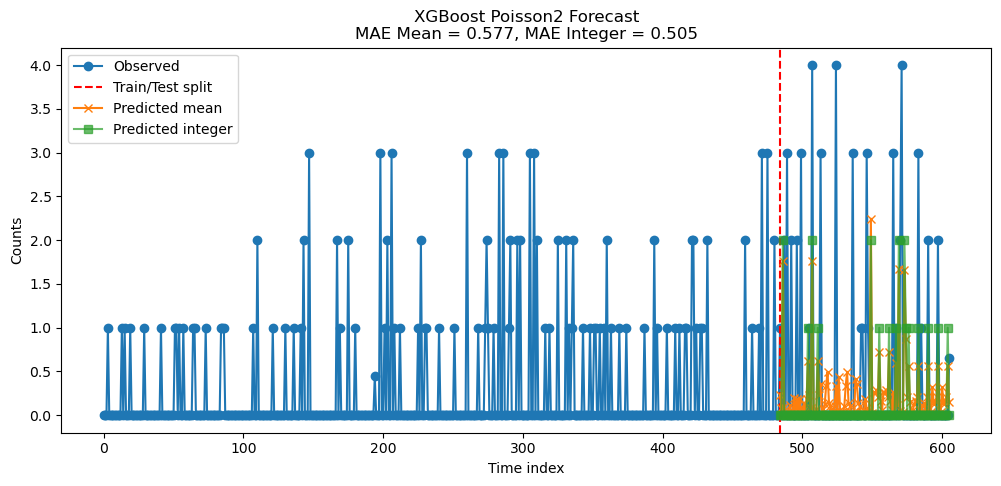

MAE (mean): 0.577
MAE (integer): 0.505
MAPE (%) mean: 0.87%
MAPE (%) integer: 0.88%
Samle (test) variance: 1.168770327240251


In [89]:
results = fit_xgb_poisson2(df_cl, test_size=0.2, max_lag=3)
print(f"MAE (mean): {results['mae_mean']:.3f}")
print(f"MAE (integer): {results['mae_integer']:.3f}")
print(f"MAPE (%) mean: {results['mape_mean']:.2f}%")
print(f"MAPE (%) integer: {results['mape_integer']:.2f}%")
print("Samle (test) variance:", results["var_test_sample"])

In [90]:
df_pred = generate_calendar('2025-09-01','2025-09-30')
n = len(df_pred)

In [91]:
df_pred = state_space_out(df_cl, df_pred, n)

In [92]:
df_out = pred_out(df_pred, SKU, var1)

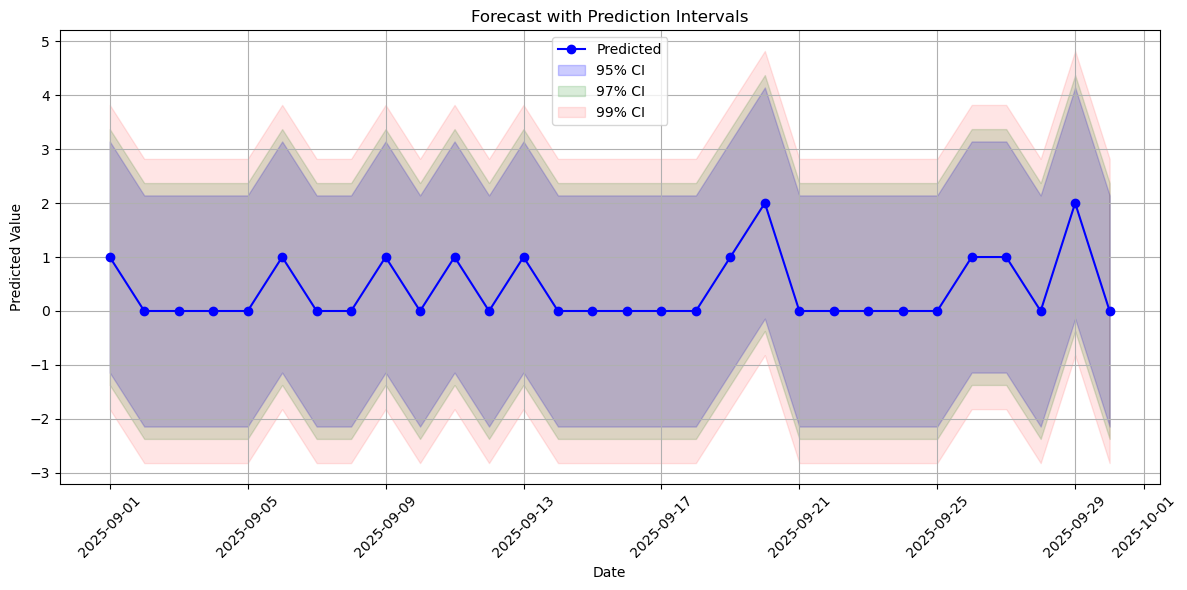

In [93]:
plot_forecast_with_intervals(df_out)

In [94]:
filename_out=f"data/mock_out.csv"
#os.remove(filename_out)

In [95]:
if os.path.exists(filename_out):
    df_out.to_csv(filename_out, mode='a', index=False, header=False)
else:
    df_out.to_csv(filename_out, mode='w', index=False, header=True)

## SKU 177714-A

In [121]:
SKU = '177714-A'
df_cl=sku_extract(df, SKU)

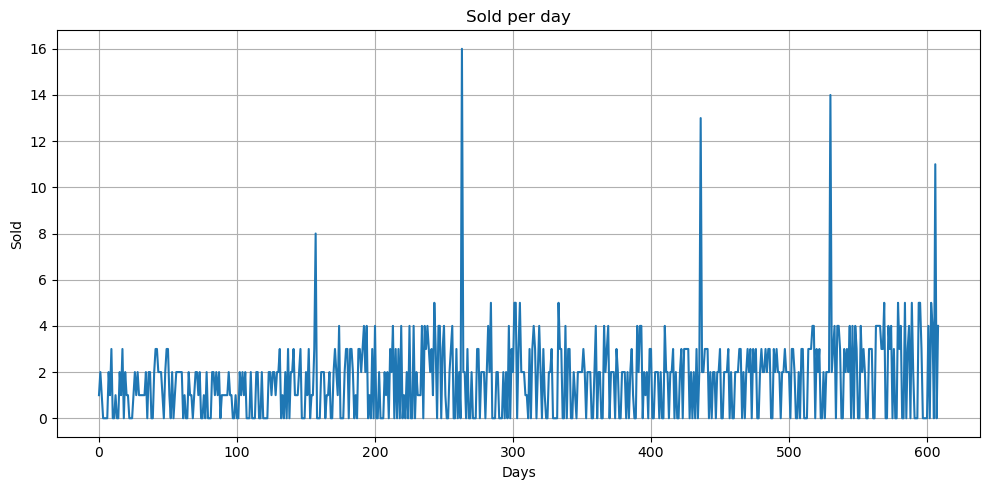

In [97]:
plot_SKU(df_cl,y_col='VALUE', title='Sold per day')

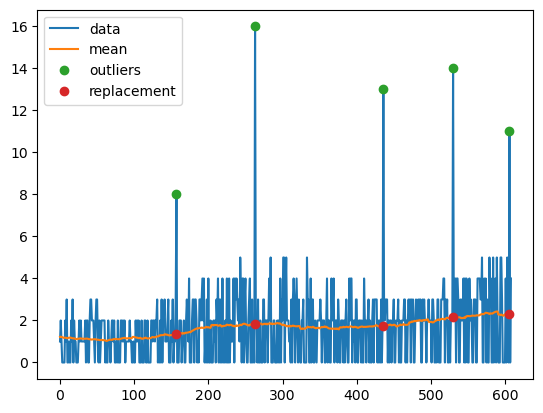

In [98]:
# outl=20
# df_cl['VALUE2'] = cap_outliers(df_cl, col='VALUE', outl=outl)['VALUE']
# plot_cap_outliers(df_cl['VALUE'],df_cl['VALUE2'],outl)
df_cl['VALUE2'] = zscore(df_cl['VALUE'], window=120)
z, avg, std, m = zscore(df_cl['VALUE'], window=120, return_all=True)
plot_zscore(df_cl, z, avg, std, m)

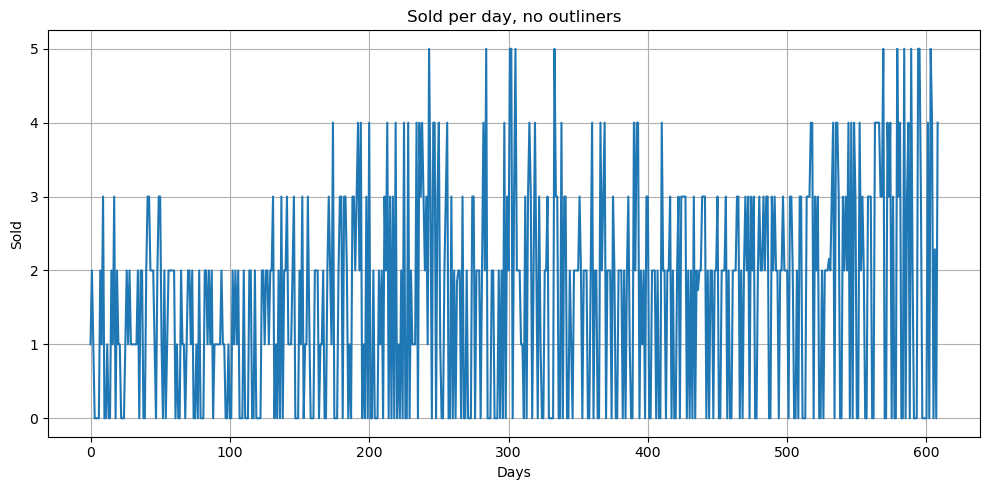

In [99]:
plot_SKU(df_cl,y_col='VALUE2', title='Sold per day, no outliners')

In [100]:
date_split(df_cl)
print(df_cl['Season'].unique())

[2 3 0 1]


<Axes: >

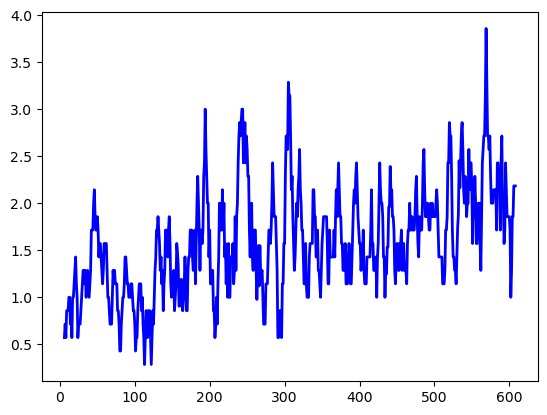

In [101]:
df_cl.loc[:, 'VALUE2'].rolling(window=7).mean().plot(
    lw=2, color='blue', label='xx-day Rolling Mean'
)

In [102]:
means_and_cor(df_cl)

--- Average 'VALUE' per Day of Week ---
   Day_of_Week  Mean_Value
0            0    1.551724
1            1    1.666667
2            2    1.571648
3            3    1.348755
4            4    1.495717
5            5    1.748946
6            6    1.689655

--- Pearson Correlation Coefficient ---
Correlation between Day of Week and Mean Value: 0.2869
Correlation between VALUE2 and Day_of_Week: 0.025416190186466018

--- Average 'VALUE' per Month ---
    Month  Mean_Value
0       1    1.354839
1       2    1.491228
2       3    1.318280
3       4    1.300000
4       5    1.516129
5       6    1.725000
6       7    1.903226
7       8    1.972350
8       9    1.461389
9      10    1.774194
10     11    1.766667
11     12    1.451613

--- Pearson Correlation Coefficient ---
Correlation between Month and Mean Value: 0.4941
Correlation between VALUE2 and Month: 0.0956613602876819
--- Average 'VALUE2' per Season ---
   Season  Mean_Value
0       0    1.868401
1       1    1.668590
2       2    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  609
Model:                            GLM   Df Residuals:                      606
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1015.5
Date:                Wed, 10 Sep 2025   Deviance:                       954.27
Time:                        13:47:49   Pearson chi2:                     721.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.05769
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1387      0.073      1.902      0.0

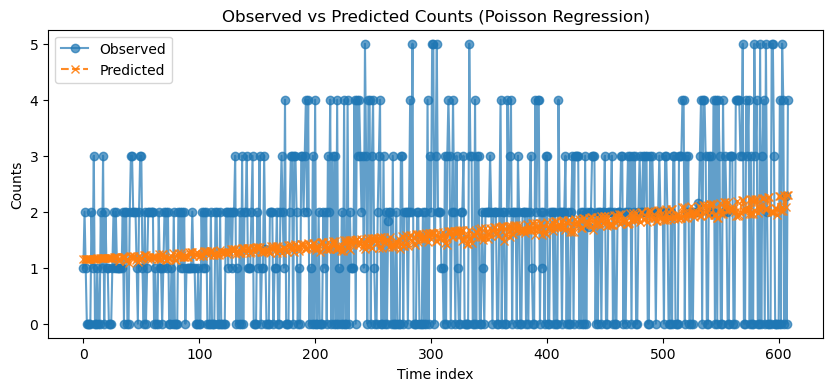

In [103]:
_ = poisson_regression(df_cl)

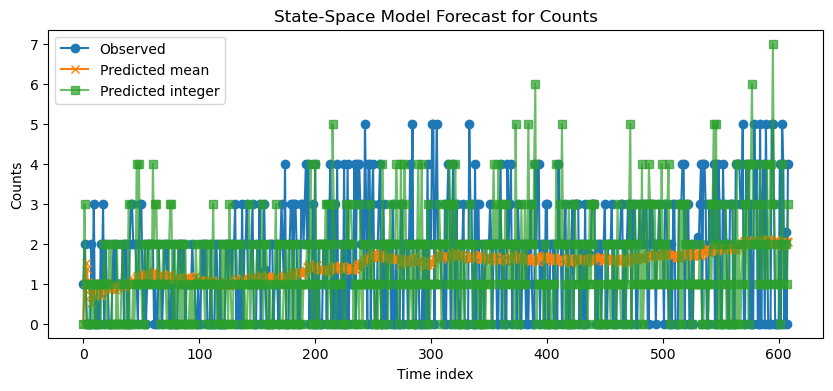

In [104]:
state_space(df_cl, seasonality_col = 'Day_of_Week')

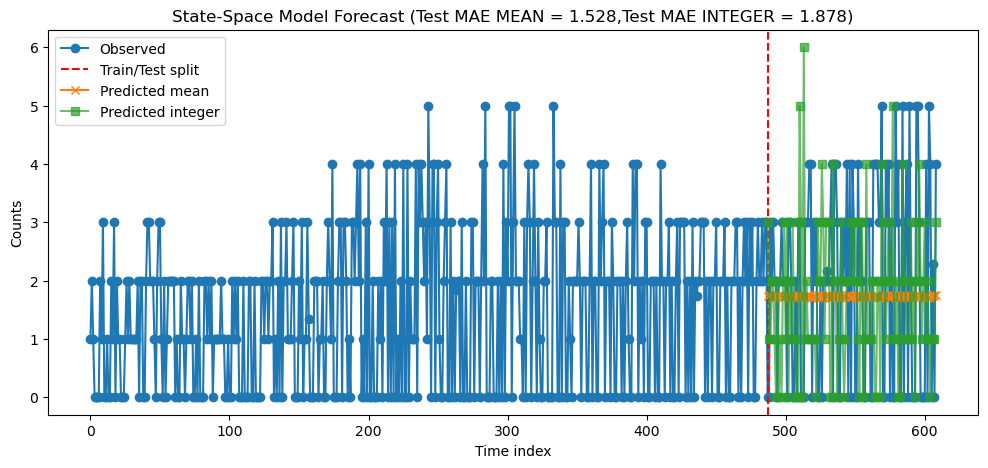

Test MAE (mean): 1.5283102565335687
Test MAE (integer): 1.8780932864949258
Test MAPE (mean): 0.3971800465654871
Test MAPE (integer): 0.574817881067881
Samle (test) variance: 4.98645838018403


In [105]:
results = fit_ucm_and_evaluate(df_cl, seasonality_col = 'Day_of_Week', test_size=0.2, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])

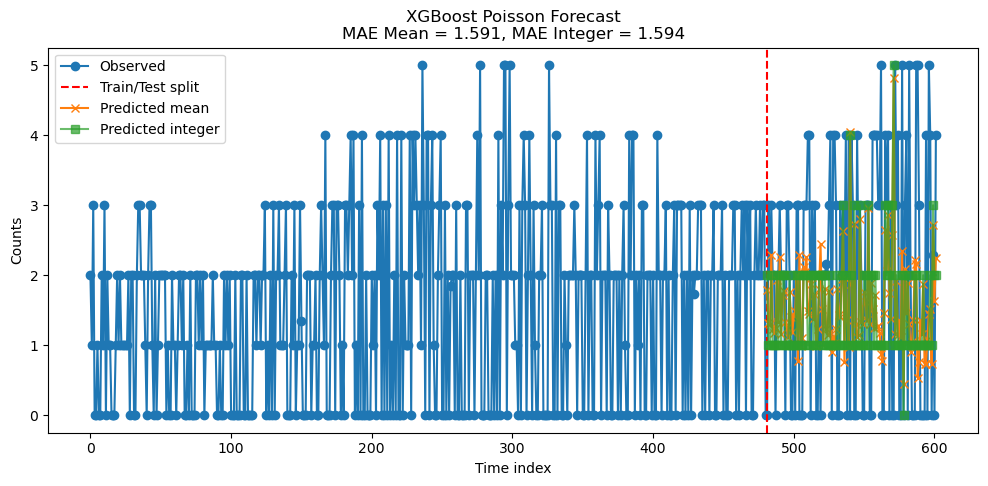

Test MAE (mean): 1.59128126834425
Test MAE (integer): 1.5939885871704054
Test MAPE (mean): 0.4625691170951079
Test MAPE (integer): 0.47926298551298546
Samle (test) variance: 3.6737661682728646


In [106]:
results = fit_xgb_poisson(df_cl, test_size=0.2, max_lag=7, plot=True)
print("Test MAE (mean):", results["mae_mean"])
print("Test MAE (integer):", results["mae_integer"])
print("Test MAPE (mean):", results["mape_mean"])
print("Test MAPE (integer):", results["mape_integer"])
print("Samle (test) variance:", results["var_test_sample"])
var1 = results["var_test_sample"]

In [107]:
df_pred = generate_calendar('2025-09-01','2025-09-30')
n = len(df_pred)

In [108]:
df_pred = fit_xgb_poisson_out(df_cl, df_pred, 7, n=30)

In [109]:
df_out = pred_out(df_pred, SKU, var1)

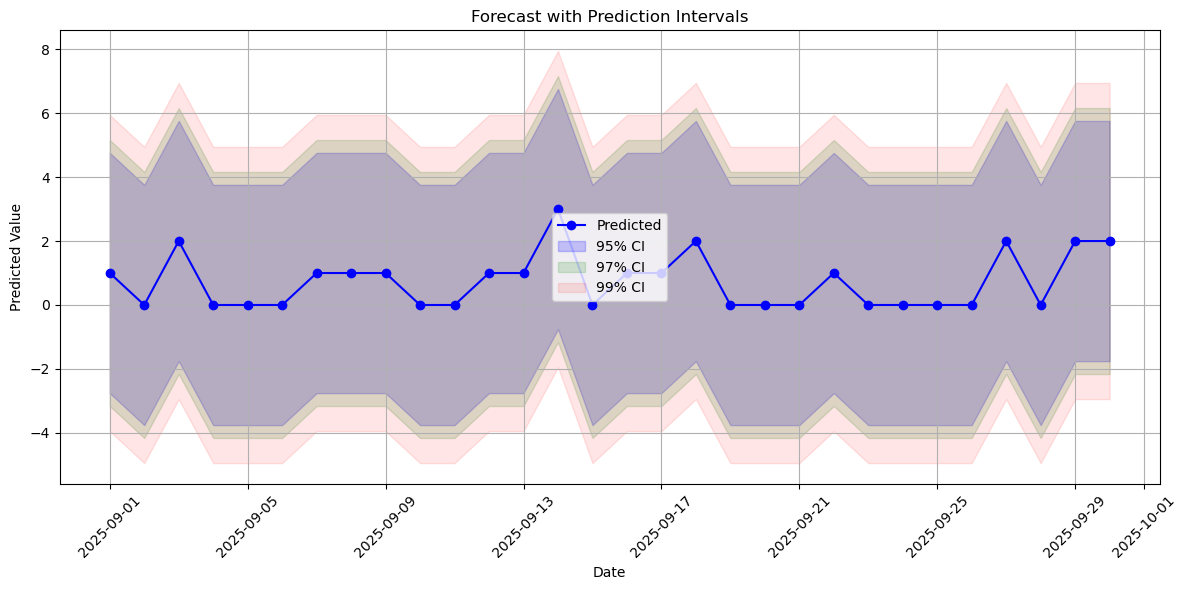

In [110]:
plot_forecast_with_intervals(df_out)

In [111]:
filename_out=f"data/mock_out.csv"
#os.remove(filename_out)

In [112]:
if os.path.exists(filename_out):
    df_out.to_csv(filename_out, mode='a', index=False, header=False)
else:
    df_out.to_csv(filename_out, mode='w', index=False, header=True)